# RNN Testing

## 1. Imports

In [1]:
import argparse
import os
import json
from typing import Optional, List
import numpy as np
import tensorflow as tf # type: ignore
from tensorflow.keras.models import load_model # type: ignore
from sklearn.metrics import f1_score

from train import (
    run_training_pipeline,
    load_and_preprocess_data_for_testing,
    MODEL_DIR,
)

from rnn import (
    SequentialFromScratch,
    SimpleRNNLayerNP,
    BidirectionalWrapperNP,
    DropoutLayerNP,
    DenseLayerNP,
    EmbeddingLayerNP,
    d_cross_entropy_softmax_np
)

## 2. Configuration Constants

In [2]:

MAX_FEATURES = 20000 
SEQUENCE_LENGTH = 150 
EMBEDDING_DIM = 256
MAIN_NUM_CLASSES = 3

print(f"Using MODEL_DIR: {MODEL_DIR}")

Using MODEL_DIR: models


## 3. Helper Function: Load Keras Model and Vectorizer

In [3]:
def load_keras_model_and_vectorizer(model_config_name: str):
    if model_config_name == "best_model":
        keras_model_filename = "best_model.keras"
    else:
        keras_model_filename = f"model_{model_config_name}.keras"
    
    keras_model_path_full = os.path.join(MODEL_DIR, keras_model_filename)

    if not os.path.exists(keras_model_path_full):
        print(f"Error: Keras model not found for '{model_config_name}'.")
        print(f"Expected Keras model: {keras_model_path_full}")
        if model_config_name != "best_model":
            print("Please ensure --train has been run for this configuration and the name is correct.")
        else:
            print("Please ensure --train has been run to generate 'best_model.keras'.")
        return None, None
        
    print(f"Loading Keras model from: {keras_model_path_full}")
    try:
        keras_model = load_model(keras_model_path_full, compile=False) 
    except Exception as e:
        print(f"Error loading Keras model: {e}")
        return None, None

    retrieved_keras_vectorizer = None
    if keras_model.layers and isinstance(keras_model.layers[0], tf.keras.layers.TextVectorization):
        retrieved_keras_vectorizer = keras_model.layers[0]
        print("TextVectorization layer successfully retrieved from the loaded Keras model.")
    else:
        print("Error: First layer of loaded Keras model is not TextVectorization or model has no layers.")
        print("The --test-scratch functionality relies on the Keras model containing the TextVectorization layer.")
        return None, None 

    return keras_model, retrieved_keras_vectorizer

## 4. Core Logic: Run From-Scratch Test

In [4]:
def run_test_scratch(model_config_name: str, inference_batch_size: Optional[int] = None, demo_backward_pass: bool = False):
    print(f"\n--- Running From-Scratch Test for model: {model_config_name} ---")
    if inference_batch_size is not None:
        print(f"--- Using inference batch size for scratch model: {inference_batch_size} ---")

    keras_model, text_vectorizer_keras = load_keras_model_and_vectorizer(model_config_name)
    if keras_model is None or text_vectorizer_keras is None:
        print("Failed to load Keras model or retrieve its vectorizer. Aborting scratch test.")
        return

    num_classes_runtime = keras_model.layers[-1].units
    print(f"Number of classes detected from Keras model's last layer: {num_classes_runtime}")

    loaded_data = load_and_preprocess_data_for_testing(for_scratch_test=True)
    if loaded_data is None or loaded_data[4] is None or loaded_data[5] is None: 
        print("Failed to load test data. Ensure data/test.csv exists and is valid.")
        return
    test_texts = loaded_data[4] 
    test_labels_raw = loaded_data[5]

    print("Vectorizing test texts using the Keras model's TextVectorization layer...")
    try:
        vectorized_test_data_tf = text_vectorizer_keras(tf.constant(test_texts, dtype=tf.string))
    except Exception as e:
        print(f"Error during TextVectorization of test_texts: {e}")
        return
        
    vectorized_test_data_np = vectorized_test_data_tf.numpy()
    print(f"Shape of vectorized test data (NumPy): {vectorized_test_data_np.shape}")

    num_rnn_layers_cfg: int
    rnn_units_cfg: int
    direction_cfg: str
    
    if model_config_name == "best_model":
        best_model_config_path = os.path.join(MODEL_DIR, "best_model_config.json")
        if not os.path.exists(best_model_config_path):
            print(f"Error: 'best_model_config.json' not found at {best_model_config_path}.")
            print("This file is needed to determine the architecture of 'best_model.keras' for the scratch model.")
            print("Please ensure --train has been run and a best model (with its config) was saved.")
            return
        try:
            with open(best_model_config_path, 'r') as f:
                config_data = json.load(f)
            num_rnn_layers_cfg = int(config_data['num_rnn_layers'])
            rnn_units_cfg = int(config_data['rnn_units'])
            direction_cfg = config_data['rnn_direction']
            if direction_cfg not in ['unidirectional', 'bidirectional']:
                raise ValueError(f"Invalid direction '{direction_cfg}' in '{best_model_config_path}'.")
            print(f"Loaded configuration for 'best_model' from JSON: Layers={num_rnn_layers_cfg}, Units={rnn_units_cfg}, Direction={direction_cfg}")
        except Exception as e:
            print(f"Error loading or parsing '{best_model_config_path}': {e}")
            return
    else:
        parts = model_config_name.split('_')
        try:
            num_rnn_layers_cfg = int(parts[parts.index('layers') + 1])
            rnn_units_cfg = int(parts[parts.index('units') + 1])
            direction_cfg = parts[parts.index('dir') + 1]
            if direction_cfg not in ['unidirectional', 'bidirectional']:
                raise ValueError(f"Invalid direction '{direction_cfg}' in model configuration name.")
        except (ValueError, IndexError) as e:
            print(f"Error parsing model configuration from name '{model_config_name}': {e}")
            return
        
    is_bidirectional_cfg = (direction_cfg == 'bidirectional')

    scratch_layers = []
    current_keras_layer_idx = 0 

    if isinstance(keras_model.layers[current_keras_layer_idx], tf.keras.layers.TextVectorization):
        current_keras_layer_idx += 1
    else:
        raise ValueError("Keras model's first layer is not TextVectorization. Inconsistency.")

    if current_keras_layer_idx < len(keras_model.layers) and \
       isinstance(keras_model.layers[current_keras_layer_idx], tf.keras.layers.Embedding):
        keras_embedding_layer = keras_model.layers[current_keras_layer_idx]
        scratch_embedding_weights = keras_embedding_layer.get_weights()[0].copy()
        scratch_embedding_layer = EmbeddingLayerNP(weights=scratch_embedding_weights)
        scratch_layers.append(scratch_embedding_layer)
        current_keras_layer_idx += 1
    else:
        raise ValueError(f"Could not find Embedding layer at expected position in Keras model. Found: {type(keras_model.layers[current_keras_layer_idx]) if current_keras_layer_idx < len(keras_model.layers) else 'No more layers'}")

    for i in range(num_rnn_layers_cfg):
        if current_keras_layer_idx >= len(keras_model.layers):
            raise ValueError(f"Keras model does not have enough layers to match num_rnn_layers_cfg={num_rnn_layers_cfg}")
            
        keras_rnn_candidate_layer = keras_model.layers[current_keras_layer_idx]
        return_sequences_np = (i < num_rnn_layers_cfg - 1) 
        
        if isinstance(keras_rnn_candidate_layer, tf.keras.layers.Bidirectional):
            if not is_bidirectional_cfg: 
                raise ValueError("Model config mismatch: Keras has Bidirectional RNN, but config suggests Unidirectional.")
            
            fw_rnn_keras = keras_rnn_candidate_layer.forward_layer
            bw_rnn_keras = keras_rnn_candidate_layer.backward_layer

            if not (isinstance(fw_rnn_keras, tf.keras.layers.SimpleRNN) and isinstance(bw_rnn_keras, tf.keras.layers.SimpleRNN)):
                 print(f"Warning: Bidirectional Keras layer contains non-SimpleRNN cells ({type(fw_rnn_keras).__name__}), but scratch test uses SimpleRNN.")

            keras_rnn_w = keras_rnn_candidate_layer.get_weights()
            if len(keras_rnn_w) < 6:
                raise ValueError(f"Bidirectional layer {keras_rnn_candidate_layer.name} does not have enough weights (expected 6, got {len(keras_rnn_w)}).")

            fw_kernel, fw_recurrent_kernel, fw_bias = keras_rnn_w[0].copy(), keras_rnn_w[1].copy(), keras_rnn_w[2].copy()
            bw_kernel, bw_recurrent_kernel, bw_bias = keras_rnn_w[3].copy(), keras_rnn_w[4].copy(), keras_rnn_w[5].copy()

            fw_rnn_np = SimpleRNNLayerNP(units=fw_rnn_keras.units, activation_fn_str=fw_rnn_keras.activation.__name__, return_sequences=return_sequences_np, go_backwards=False)
            fw_rnn_np.load_weights(kernel=fw_kernel, recurrent_kernel=fw_recurrent_kernel, bias=fw_bias)
            
            bw_rnn_np = SimpleRNNLayerNP(units=bw_rnn_keras.units, activation_fn_str=bw_rnn_keras.activation.__name__, return_sequences=return_sequences_np, go_backwards=True)
            bw_rnn_np.load_weights(kernel=bw_kernel, recurrent_kernel=bw_recurrent_kernel, bias=bw_bias)
            
            bi_rnn_np = BidirectionalWrapperNP(forward_layer=fw_rnn_np, backward_layer=bw_rnn_np, return_sequences=return_sequences_np)
            scratch_layers.append(bi_rnn_np)
            current_keras_layer_idx += 1

        elif isinstance(keras_rnn_candidate_layer, (tf.keras.layers.SimpleRNN, tf.keras.layers.GRU, tf.keras.layers.LSTM)): 
            if is_bidirectional_cfg: 
                raise ValueError("Model config mismatch: Keras has Unidirectional RNN, but config suggests Bidirectional.")
            if not isinstance(keras_rnn_candidate_layer, tf.keras.layers.SimpleRNN):
                 print(f"Warning: Unidirectional Keras layer is of type {type(keras_rnn_candidate_layer).__name__}, but scratch test uses SimpleRNN.")


            keras_rnn_w = keras_rnn_candidate_layer.get_weights() 
            if len(keras_rnn_w) < 3:
                 raise ValueError(f"Unidirectional RNN layer {keras_rnn_candidate_layer.name} does not have enough weights (expected 3, got {len(keras_rnn_w)}).")
            
            uni_kernel, uni_recurrent_kernel, uni_bias = keras_rnn_w[0].copy(), keras_rnn_w[1].copy(), keras_rnn_w[2].copy()

            rnn_np = SimpleRNNLayerNP(units=keras_rnn_candidate_layer.units, activation_fn_str=keras_rnn_candidate_layer.activation.__name__, return_sequences=return_sequences_np, go_backwards=False)
            rnn_np.load_weights(kernel=uni_kernel, recurrent_kernel=uni_recurrent_kernel, bias=uni_bias)
            scratch_layers.append(rnn_np)
            current_keras_layer_idx += 1
        else:
            raise ValueError(f"Unexpected Keras RNN layer type encountered: {type(keras_rnn_candidate_layer)} at index {current_keras_layer_idx}.")

    if current_keras_layer_idx < len(keras_model.layers) and \
       isinstance(keras_model.layers[current_keras_layer_idx], tf.keras.layers.Dropout):
        keras_dropout_layer = keras_model.layers[current_keras_layer_idx]
        scratch_dropout_layer = DropoutLayerNP(rate=keras_dropout_layer.rate)
        scratch_layers.append(scratch_dropout_layer)
        current_keras_layer_idx +=1
    
    if current_keras_layer_idx < len(keras_model.layers) and \
       isinstance(keras_model.layers[current_keras_layer_idx], tf.keras.layers.Dense):
        keras_dense_layer = keras_model.layers[current_keras_layer_idx]
    else:
        raise ValueError(f"Expected Dense layer, got {type(keras_model.layers[current_keras_layer_idx]) if current_keras_layer_idx < len(keras_model.layers) else 'No more layers'}")
    
    dense_weights_keras = keras_dense_layer.get_weights()
    if len(dense_weights_keras) < 2:
        raise ValueError(f"Dense layer {keras_dense_layer.name} does not have enough weights (expected 2, got {len(dense_weights_keras)}).")

    dense_activation = keras_dense_layer.activation.__name__ if keras_dense_layer.activation else 'linear'
    if dense_activation != 'softmax':
        print(f"Warning: Keras final Dense layer activation is '{dense_activation}', not 'softmax'.")
        print("The from-scratch DenseLayerNP will use 'softmax' as configured in rnn.py for probability output.")

    dense_kernel, dense_bias = dense_weights_keras[0].copy(), dense_weights_keras[1].copy()
    scratch_dense_layer = DenseLayerNP(units=keras_dense_layer.units, activation_fn_str='softmax') 
    scratch_dense_layer.load_weights(kernel=dense_kernel, bias=dense_bias)
    scratch_layers.append(scratch_dense_layer)

    scratch_model = SequentialFromScratch(layers=scratch_layers)
    
    if demo_backward_pass:
        print("\n--- Running Backward Pass Demonstration ---")
        demo_batch_size = min(5, vectorized_test_data_np.shape[0])
        if demo_batch_size == 0:
            print("Not enough test data for backward pass demo.")
        else:
            demo_input_batch = vectorized_test_data_np[:demo_batch_size]
            demo_labels_batch = test_labels_raw[:demo_batch_size]
            print(f"Using {demo_batch_size} samples for backward pass demo.")
            print("1. Performing forward pass (training=True)...")
            predictions_proba_demo = scratch_model.forward(demo_input_batch, training=True)
            print("2. Calculating initial gradient (dL/dLogits)...")
            dL_dLogits_demo = d_cross_entropy_softmax_np(predictions_proba_demo, demo_labels_batch, num_classes_runtime)
            print("3. Performing backward pass (training=True)...")
            scratch_model.backward(dL_dLogits_demo, training=True)
            print("Backward pass demo executed. Gradients have been computed in scratch model layers (weights NOT updated).")
            for i, layer in enumerate(scratch_model.layers):
                if hasattr(layer, 'gradients') and layer.gradients:
                    print(f"  Gradients computed for layer {i} ({type(layer).__name__}):")
                    for grad_name, grad_val in layer.gradients.items():
                        print(f"    - {grad_name}: shape {grad_val.shape}, sum {np.sum(grad_val):.4e}")
            print("--- End of Backward Pass Demonstration ---\n")
            
    print("Getting from-scratch model predictions (for inference comparison)...")
    if inference_batch_size is None:
        scratch_predictions_proba = scratch_model.forward(vectorized_test_data_np, training=False)
    else:
        num_samples = vectorized_test_data_np.shape[0]
        all_outputs_scratch = []
        print(f"Running scratch model inference in batches of size {inference_batch_size}...")
        for i_batch in range(0, num_samples, inference_batch_size):
            batch_input_np = vectorized_test_data_np[i_batch:min(i_batch + inference_batch_size, num_samples)]
            batch_output_scratch = scratch_model.forward(batch_input_np, training=False) 
            all_outputs_scratch.append(batch_output_scratch)
        scratch_predictions_proba = np.concatenate(all_outputs_scratch, axis=0)

    print("Getting Keras model predictions (for comparison)...")
    keras_predictions_proba = keras_model.predict(tf.constant(test_texts, dtype=tf.string), batch_size=inference_batch_size if inference_batch_size else 32)

    print(f"Shape of Keras predicted probabilities: {keras_predictions_proba.shape}")
    print(f"Shape of Scratch predicted probabilities: {scratch_predictions_proba.shape}")

    if np.any(np.isnan(scratch_predictions_proba)) or np.any(np.isinf(scratch_predictions_proba)):
        print("Error: NaN or Inf found in scratch model predictions. This indicates a numerical issue.")
    elif np.allclose(keras_predictions_proba, scratch_predictions_proba, atol=1e-5): 
        print("\nSUCCESS: Keras and From-Scratch model probability outputs are very close!")
    else:
        print("\nWARNING: Keras and From-Scratch model probability outputs differ significantly.")
        diff = np.abs(keras_predictions_proba - scratch_predictions_proba)
        print(f"Max absolute difference in probabilities: {np.max(diff):.6e}")
        print(f"Mean absolute difference in probabilities: {np.mean(diff):.6e}")
        for i_sample in range(min(3, keras_predictions_proba.shape[0])): 
            print(f"Sample {i_sample}:")
            print(f"  Keras:  {keras_predictions_proba[i_sample]}")
            print(f"  Scratch:{scratch_predictions_proba[i_sample]}")
            print(f"  Diff:   {keras_predictions_proba[i_sample] - scratch_predictions_proba[i_sample]}")

    keras_predicted_labels = np.argmax(keras_predictions_proba, axis=1)
    scratch_predicted_labels = np.argmax(scratch_predictions_proba, axis=1)

    keras_f1 = f1_score(test_labels_raw, keras_predicted_labels, average='macro', zero_division=0)
    scratch_f1 = f1_score(test_labels_raw, scratch_predicted_labels, average='macro', zero_division=0)

    print(f"\nMacro F1 Score (Keras): {keras_f1:.4f}")
    print(f"Macro F1 Score (From-Scratch): {scratch_f1:.4f}")

    if np.array_equal(keras_predicted_labels, scratch_predicted_labels):
        print("SUCCESS: Predicted labels from Keras and Scratch models are identical.")
    else:
        mismatches = np.sum(keras_predicted_labels != scratch_predicted_labels)
        total_samples = len(test_labels_raw)
        print(f"WARNING: Predicted labels differ for {mismatches}/{total_samples} samples ({mismatches/total_samples*100:.2f}% mismatch).")

## 5. Main Function

In [5]:
def main_function(args_list: Optional[List[str]] = None):
    parser = argparse.ArgumentParser(description="End-to-end text classification pipeline for notebook.")
    parser.add_argument(
        '--train',
        action='store_true',
        help="Run the full training pipeline with hyperparameter sweep."
    )
    parser.add_argument(
        '--test-scratch',
        type=str,
        metavar='MODEL_NAME_OR_CONFIG',
        help="Compare Keras forward pass with from-scratch implementation. "
             "Provide the model configuration name (e.g., 'layers_1_units_64_dir_unidirectional') OR 'best_model'."
    )
    parser.add_argument(
        '--inference-batch-size',
        type=int,
        default=None, 
        help="Batch size for from-scratch model inference during --test-scratch. "
             "Processes all test data at once if not set. Also used for Keras model.predict batch_size."
    )
    parser.add_argument(
        '--demo-backward',
        action='store_true',
        help="Run a demonstration of the backward pass on a small batch when using --test-scratch. "
             "This will compute gradients but not update weights for the main comparison."
    )

    if args_list is None:
        args = parser.parse_args() 
    else:
        args = parser.parse_args(args_list)

    if args.train:
        if not os.path.exists("data"):
            os.makedirs("data")
            print("Created 'data' directory. Please place train.csv, valid.csv, and test.csv there for training.")
        
        required_files = ['data/train.csv', 'data/valid.csv', 'data/test.csv']
        missing_files = [f for f in required_files if not os.path.exists(f)]
        if missing_files:
            print(f"Error: Missing data file(s) for training: {', '.join(missing_files)}")
            print("Please ensure train.csv, valid.csv, and test.csv are in the 'data' directory before training.")
            return 

    if args.train:
        print("Starting training pipeline...")
        run_training_pipeline()
        print("Training pipeline finished.")
    elif args.test_scratch:
        print(f"Starting from-scratch test for: {args.test_scratch}")
        run_test_scratch(args.test_scratch, args.inference_batch_size, args.demo_backward)
        print("From-scratch test finished.")
    else:
        print("No action specified. Provide arguments like ['--train'] or ['--test-scratch', 'model_name'].")

## 6. Setup Directories

Run this cell once to ensure necessary directories (`models`, `plots`, `data`) exist.

In [6]:
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)
    print(f"Created directory: {MODEL_DIR}")
else:
    print(f"Directory already exists: {MODEL_DIR}")

if not os.path.exists("plots"):
    os.makedirs("plots")
    print("Created directory: plots")
else:
    print("Directory already exists: plots")

if not os.path.exists("data"):
    os.makedirs("data")
    print("Created 'data' directory. Reminder: place train.csv, valid.csv, and test.csv here for training.")
else:
    print("Directory already exists: data. Ensure CSV files are present for training.")

Created directory: models
Created directory: plots
Directory already exists: data. Ensure CSV files are present for training.


## 7. Notebook Execution

### 7.1 Run Training Pipeline

Attempting to run training pipeline...
Starting training pipeline...
Starting Keras training pipeline...
Loaded 500 samples from data/train.csv. Label mapping: {'negative': np.int64(0), 'neutral': np.int64(1), 'positive': np.int64(2)}
Loaded 100 samples from data/valid.csv. Label mapping: {'negative': np.int64(0), 'neutral': np.int64(1), 'positive': np.int64(2)}
Loaded 400 samples from data/test.csv. Label mapping: {'negative': np.int64(0), 'neutral': np.int64(1), 'positive': np.int64(2)}
Adapting shared TextVectorization layer on training data...
Shared TextVectorization vocabulary and config saved to models\shared_vectorizer_vocab.json

--- Starting Hyperparameter Sweep ---

>>>> CONFIGURATION: layers_1_units_32_dir_unidirectional (RNN Type: SimpleRNN) <<<<

--- Training model: model_layers_1_units_32_dir_unidirectional ---
Model model_layers_1_units_32_dir_unidirectional built with input shape: (None,)


c:\Users\saput\OneDrive\Desktop\Kuliah\Semester 6\ML\CNNxRNN\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "model_layers_1_units_32_dir_unidirectional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ shared_text_vectorizer          │ (None, 120)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 120, 256)       │     5,120,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simplernn (SimpleRNN)           │ (None, 32)             │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_dense (Dense)            │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,129,347 (19.57 MB)

 Trainable params: 5,129,347 (19.57 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20

Epoch 1: val_loss improved from inf to 1.09235, saving model to models\model_layers_1_units_32_dir_unidirectional.keras
16/16 - 4s - 238ms/step - accuracy: 0.3460 - loss: 1.1210 - val_accuracy: 0.3800 - val_loss: 1.0923
Epoch 2/20

Epoch 2: val_loss did not improve from 1.09235
16/16 - 1s - 54ms/step - accuracy: 0.5820 - loss: 0.9374 - val_accuracy: 0.4000 - val_loss: 1.1322
Epoch 3/20

Epoch 3: val_loss did not improve from 1.09235
16/16 - 1s - 55ms/step - accuracy: 0.7980 - loss: 0.6936 - val_accuracy: 0.4400 - val_loss: 1.1401
Epoch 4/20

Epoch 4: val_loss did not improve from 1.09235
16/16 - 1s - 55ms/step - accuracy: 0.9300 - loss: 0.4861 - val_accuracy: 0.3500 - val_loss: 1.2259
Epoch 5/20

Epoch 5: val_loss did not improve from 1.09235
16/16 - 1s - 54ms/step - accuracy: 0.9780 - loss: 0.3235 - val_accuracy: 0.4200 - val_loss: 1.2003
Epoch 6/20

Epoch 6: val_loss did not improve from 1.09235
16/16 - 1s - 56ms/step - accuracy: 0.9940 - loss: 0.2104 - val_accuracy: 0.46

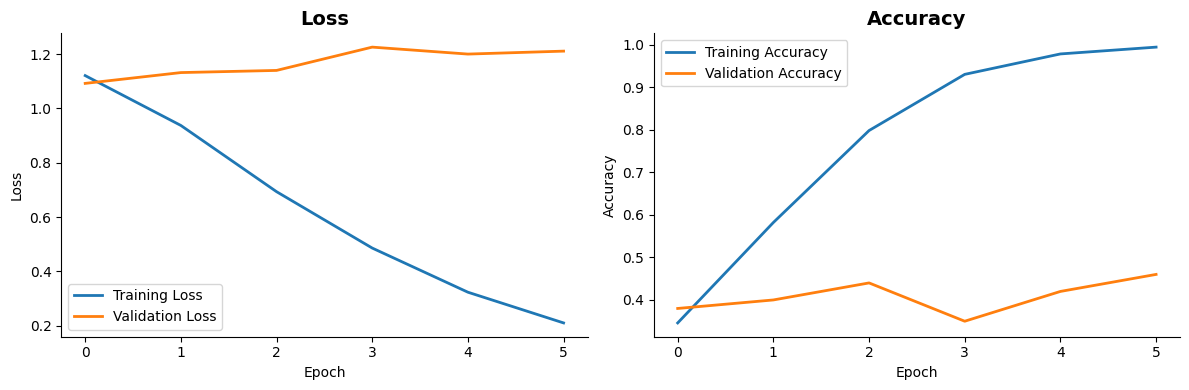

Displaying plot for 0.1 seconds...
Plot closed.
Loading best version of model_layers_1_units_32_dir_unidirectional from models\model_layers_1_units_32_dir_unidirectional.keras for final evaluation.
First layer of loaded_model_for_this_config (model_layers_1_units_32_dir_unidirectional) is: shared_text_vectorizer (type: <class 'keras.src.layers.preprocessing.text_vectorization.TextVectorization'>)
Evaluating model model_layers_1_units_32_dir_unidirectional on test data...
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
Test Macro F1-Score for model_layers_1_units_32_dir_unidirectional: 0.1827
New best overall model 'models\model_layers_1_units_32_dir_unidirectional.keras' copied to 'models\best_model.keras' (Macro F1: 0.1827)
Best overall model configuration saved to models\best_model_config.json


>>>> CONFIGURATION: layers_1_units_32_dir_bidirectional (RNN Type: SimpleRNN) <<<<

--- Training model: model_layers_1_units_32_dir_bidirectional ---
Model model_layers_1_units_32_dir_bidirectional b

c:\Users\saput\OneDrive\Desktop\Kuliah\Semester 6\ML\CNNxRNN\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "model_layers_1_units_32_dir_bidirectional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ shared_text_vectorizer          │ (None, 120)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 120, 256)       │     5,120,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_simplernn         │ (None, 64)             │        18,496 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_dense (Dense)            │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,138,691 (19.60 MB)

 Trainable params: 5,138,691 (19.60 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20

Epoch 1: val_loss improved from inf to 0.94629, saving model to models\model_layers_1_units_32_dir_bidirectional.keras
16/16 - 7s - 447ms/step - accuracy: 0.4300 - loss: 1.0584 - val_accuracy: 0.6000 - val_loss: 0.9463
Epoch 2/20

Epoch 2: val_loss improved from 0.94629 to 0.87244, saving model to models\model_layers_1_units_32_dir_bidirectional.keras
16/16 - 2s - 115ms/step - accuracy: 0.7760 - loss: 0.6820 - val_accuracy: 0.5900 - val_loss: 0.8724
Epoch 3/20

Epoch 3: val_loss improved from 0.87244 to 0.84562, saving model to models\model_layers_1_units_32_dir_bidirectional.keras
16/16 - 2s - 104ms/step - accuracy: 0.9160 - loss: 0.4283 - val_accuracy: 0.5700 - val_loss: 0.8456
Epoch 4/20

Epoch 4: val_loss did not improve from 0.84562
16/16 - 1s - 68ms/step - accuracy: 0.9760 - loss: 0.2496 - val_accuracy: 0.5900 - val_loss: 0.8821
Epoch 5/20

Epoch 5: val_loss did not improve from 0.84562
16/16 - 1s - 69ms/step - accuracy: 0.9960 - loss: 0.1430 - val_accuracy: 0.6000 - 

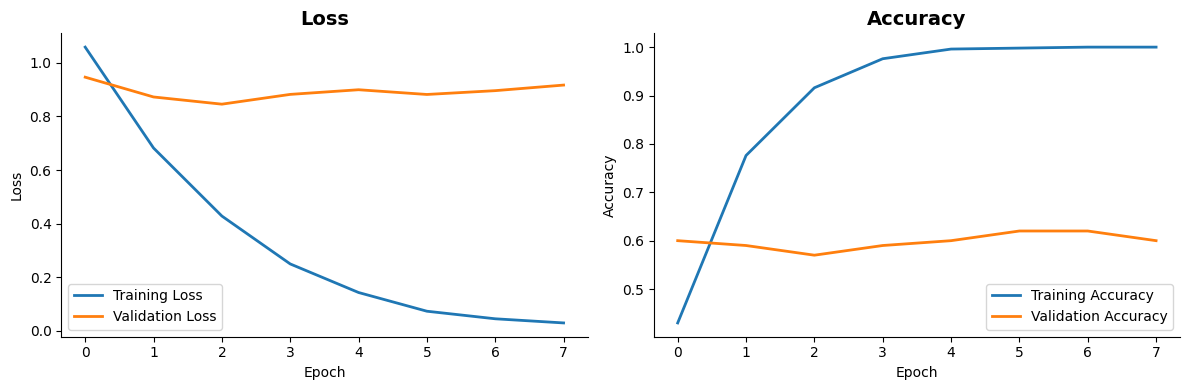

Displaying plot for 0.1 seconds...
Plot closed.
Loading best version of model_layers_1_units_32_dir_bidirectional from models\model_layers_1_units_32_dir_bidirectional.keras for final evaluation.
First layer of loaded_model_for_this_config (model_layers_1_units_32_dir_bidirectional) is: shared_text_vectorizer (type: <class 'keras.src.layers.preprocessing.text_vectorization.TextVectorization'>)
Evaluating model model_layers_1_units_32_dir_bidirectional on test data...
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step
Test Macro F1-Score for model_layers_1_units_32_dir_bidirectional: 0.5368
New best overall model 'models\model_layers_1_units_32_dir_bidirectional.keras' copied to 'models\best_model.keras' (Macro F1: 0.5368)
Best overall model configuration saved to models\best_model_config.json

>>>> CONFIGURATION: layers_1_units_64_dir_unidirectional (RNN Type: SimpleRNN) <<<<

--- Training model: model_layers_1_units_64_dir_unidirectional ---
Model model_layers_1_units_64_dir_unidirectional built

c:\Users\saput\OneDrive\Desktop\Kuliah\Semester 6\ML\CNNxRNN\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "model_layers_1_units_64_dir_unidirectional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ shared_text_vectorizer          │ (None, 120)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 120, 256)       │     5,120,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simplernn (SimpleRNN)           │ (None, 64)             │        20,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_dense (Dense)            │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,140,739 (19.61 MB)

 Trainable params: 5,140,739 (19.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20

Epoch 1: val_loss improved from inf to 1.07876, saving model to models\model_layers_1_units_64_dir_unidirectional.keras
16/16 - 5s - 291ms/step - accuracy: 0.3500 - loss: 1.0953 - val_accuracy: 0.3800 - val_loss: 1.0788
Epoch 2/20

Epoch 2: val_loss did not improve from 1.07876
16/16 - 1s - 53ms/step - accuracy: 0.3820 - loss: 1.0917 - val_accuracy: 0.3700 - val_loss: 1.0841
Epoch 3/20

Epoch 3: val_loss did not improve from 1.07876
16/16 - 1s - 53ms/step - accuracy: 0.5300 - loss: 0.9486 - val_accuracy: 0.3900 - val_loss: 1.1973
Epoch 4/20

Epoch 4: val_loss did not improve from 1.07876
16/16 - 1s - 56ms/step - accuracy: 0.6100 - loss: 0.8431 - val_accuracy: 0.3800 - val_loss: 1.1795
Epoch 5/20

Epoch 5: val_loss did not improve from 1.07876
16/16 - 1s - 52ms/step - accuracy: 0.7860 - loss: 0.6260 - val_accuracy: 0.4400 - val_loss: 1.1456
Epoch 6/20

Epoch 6: val_loss did not improve from 1.07876
16/16 - 1s - 52ms/step - accuracy: 0.9160 - loss: 0.4011 - val_accuracy: 0.34

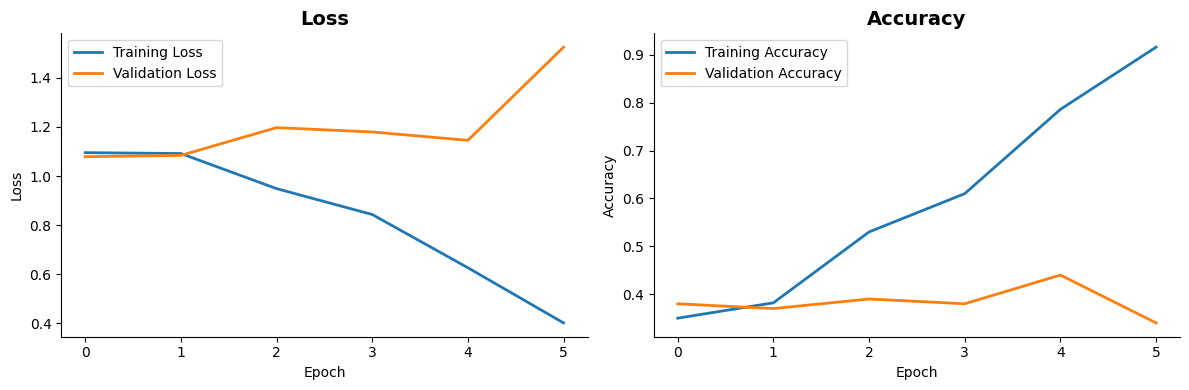

Displaying plot for 0.1 seconds...
Plot closed.
Loading best version of model_layers_1_units_64_dir_unidirectional from models\model_layers_1_units_64_dir_unidirectional.keras for final evaluation.
First layer of loaded_model_for_this_config (model_layers_1_units_64_dir_unidirectional) is: shared_text_vectorizer (type: <class 'keras.src.layers.preprocessing.text_vectorization.TextVectorization'>)
Evaluating model model_layers_1_units_64_dir_unidirectional on test data...
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
Test Macro F1-Score for model_layers_1_units_64_dir_unidirectional: 0.1827

>>>> CONFIGURATION: layers_1_units_64_dir_bidirectional (RNN Type: SimpleRNN) <<<<

--- Training model: model_layers_1_units_64_dir_bidirectional ---
Model model_layers_1_units_64_dir_bidirectional built with input shape: (None,)


c:\Users\saput\OneDrive\Desktop\Kuliah\Semester 6\ML\CNNxRNN\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "model_layers_1_units_64_dir_bidirectional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ shared_text_vectorizer          │ (None, 120)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 120, 256)       │     5,120,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_simplernn         │ (None, 128)            │        41,088 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_dense (Dense)            │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,161,475 (19.69 MB)

 Trainable params: 5,161,475 (19.69 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20

Epoch 1: val_loss improved from inf to 0.96663, saving model to models\model_layers_1_units_64_dir_bidirectional.keras
16/16 - 7s - 465ms/step - accuracy: 0.4640 - loss: 1.0021 - val_accuracy: 0.5400 - val_loss: 0.9666
Epoch 2/20

Epoch 2: val_loss improved from 0.96663 to 0.89439, saving model to models\model_layers_1_units_64_dir_bidirectional.keras
16/16 - 2s - 106ms/step - accuracy: 0.7240 - loss: 0.7165 - val_accuracy: 0.5700 - val_loss: 0.8944
Epoch 3/20

Epoch 3: val_loss improved from 0.89439 to 0.83470, saving model to models\model_layers_1_units_64_dir_bidirectional.keras
16/16 - 1s - 91ms/step - accuracy: 0.9480 - loss: 0.4110 - val_accuracy: 0.6400 - val_loss: 0.8347
Epoch 4/20

Epoch 4: val_loss did not improve from 0.83470
16/16 - 1s - 64ms/step - accuracy: 0.9820 - loss: 0.1863 - val_accuracy: 0.6500 - val_loss: 0.8507
Epoch 5/20

Epoch 5: val_loss improved from 0.83470 to 0.79256, saving model to models\model_layers_1_units_64_dir_bidirectional.keras
16/16 -

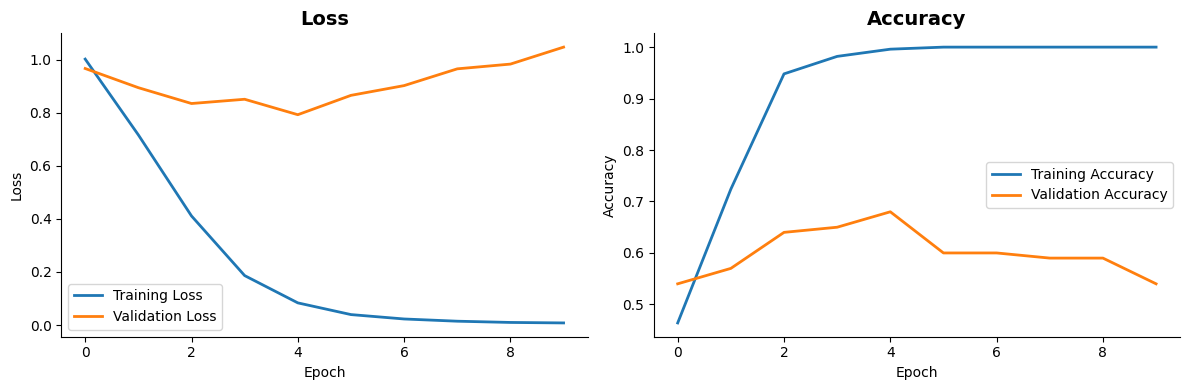

Displaying plot for 0.1 seconds...
Plot closed.
Loading best version of model_layers_1_units_64_dir_bidirectional from models\model_layers_1_units_64_dir_bidirectional.keras for final evaluation.
First layer of loaded_model_for_this_config (model_layers_1_units_64_dir_bidirectional) is: shared_text_vectorizer (type: <class 'keras.src.layers.preprocessing.text_vectorization.TextVectorization'>)
Evaluating model model_layers_1_units_64_dir_bidirectional on test data...
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
Test Macro F1-Score for model_layers_1_units_64_dir_bidirectional: 0.5920
New best overall model 'models\model_layers_1_units_64_dir_bidirectional.keras' copied to 'models\best_model.keras' (Macro F1: 0.5920)
Best overall model configuration saved to models\best_model_config.json

>>>> CONFIGURATION: layers_1_units_128_dir_unidirectional (RNN Type: SimpleRNN) <<<<

--- Training model: model_layers_1_units_128_dir_unidirectional ---
Model model_layers_1_units_128_dir_unidirectional bu

c:\Users\saput\OneDrive\Desktop\Kuliah\Semester 6\ML\CNNxRNN\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "model_layers_1_units_128_dir_unidirectional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ shared_text_vectorizer          │ (None, 120)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 120, 256)       │     5,120,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simplernn (SimpleRNN)           │ (None, 128)            │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_dense (Dense)            │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,169,667 (19.72 MB)

 Trainable params: 5,169,667 (19.72 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20

Epoch 1: val_loss improved from inf to 1.07330, saving model to models\model_layers_1_units_128_dir_unidirectional.keras
16/16 - 4s - 229ms/step - accuracy: 0.3380 - loss: 1.1158 - val_accuracy: 0.5200 - val_loss: 1.0733
Epoch 2/20

Epoch 2: val_loss did not improve from 1.07330
16/16 - 1s - 51ms/step - accuracy: 0.3840 - loss: 1.1029 - val_accuracy: 0.3800 - val_loss: 1.0855
Epoch 3/20

Epoch 3: val_loss did not improve from 1.07330
16/16 - 1s - 54ms/step - accuracy: 0.3560 - loss: 1.1385 - val_accuracy: 0.3800 - val_loss: 1.0876
Epoch 4/20

Epoch 4: val_loss did not improve from 1.07330
16/16 - 1s - 54ms/step - accuracy: 0.4020 - loss: 1.1087 - val_accuracy: 0.3600 - val_loss: 1.1201
Epoch 5/20

Epoch 5: val_loss did not improve from 1.07330
16/16 - 1s - 51ms/step - accuracy: 0.3940 - loss: 1.1015 - val_accuracy: 0.4400 - val_loss: 1.1076
Epoch 6/20

Epoch 6: val_loss did not improve from 1.07330
16/16 - 1s - 51ms/step - accuracy: 0.3660 - loss: 1.1235 - val_accuracy: 0.3

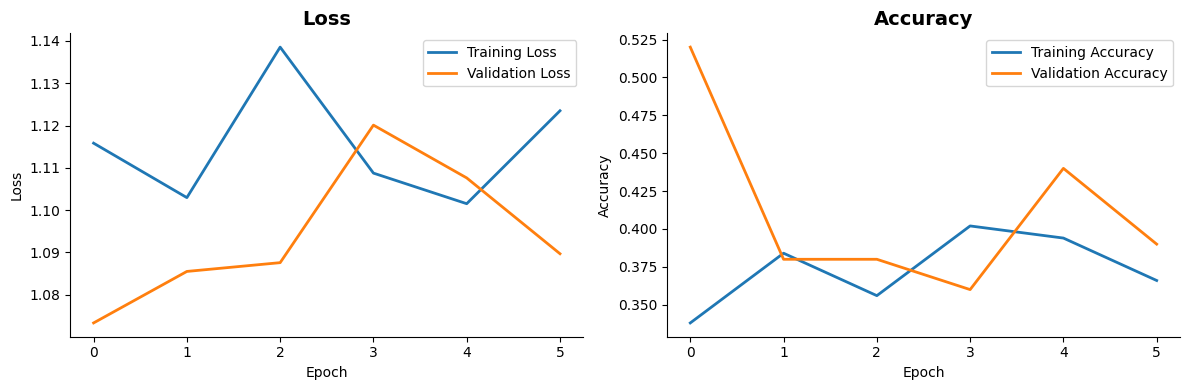

Displaying plot for 0.1 seconds...
Plot closed.
Loading best version of model_layers_1_units_128_dir_unidirectional from models\model_layers_1_units_128_dir_unidirectional.keras for final evaluation.
First layer of loaded_model_for_this_config (model_layers_1_units_128_dir_unidirectional) is: shared_text_vectorizer (type: <class 'keras.src.layers.preprocessing.text_vectorization.TextVectorization'>)
Evaluating model model_layers_1_units_128_dir_unidirectional on test data...
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
Test Macro F1-Score for model_layers_1_units_128_dir_unidirectional: 0.3313

>>>> CONFIGURATION: layers_1_units_128_dir_bidirectional (RNN Type: SimpleRNN) <<<<

--- Training model: model_layers_1_units_128_dir_bidirectional ---
Model model_layers_1_units_128_dir_bidirectional built with input shape: (None,)


c:\Users\saput\OneDrive\Desktop\Kuliah\Semester 6\ML\CNNxRNN\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "model_layers_1_units_128_dir_bidirectional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ shared_text_vectorizer          │ (None, 120)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 120, 256)       │     5,120,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_simplernn         │ (None, 256)            │        98,560 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_dense (Dense)            │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,219,331 (19.91 MB)

 Trainable params: 5,219,331 (19.91 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20

Epoch 1: val_loss improved from inf to 0.99748, saving model to models\model_layers_1_units_128_dir_bidirectional.keras
16/16 - 5s - 337ms/step - accuracy: 0.4380 - loss: 1.0376 - val_accuracy: 0.5000 - val_loss: 0.9975
Epoch 2/20

Epoch 2: val_loss improved from 0.99748 to 0.95988, saving model to models\model_layers_1_units_128_dir_bidirectional.keras
16/16 - 2s - 96ms/step - accuracy: 0.7320 - loss: 0.6941 - val_accuracy: 0.5500 - val_loss: 0.9599
Epoch 3/20

Epoch 3: val_loss did not improve from 0.95988
16/16 - 1s - 70ms/step - accuracy: 0.9420 - loss: 0.3699 - val_accuracy: 0.5400 - val_loss: 0.9840
Epoch 4/20

Epoch 4: val_loss did not improve from 0.95988
16/16 - 1s - 66ms/step - accuracy: 0.9840 - loss: 0.1307 - val_accuracy: 0.5800 - val_loss: 0.9936
Epoch 5/20

Epoch 5: val_loss did not improve from 0.95988
16/16 - 1s - 71ms/step - accuracy: 0.9940 - loss: 0.0508 - val_accuracy: 0.5900 - val_loss: 0.9842
Epoch 6/20

Epoch 6: val_loss did not improve from 0.95988


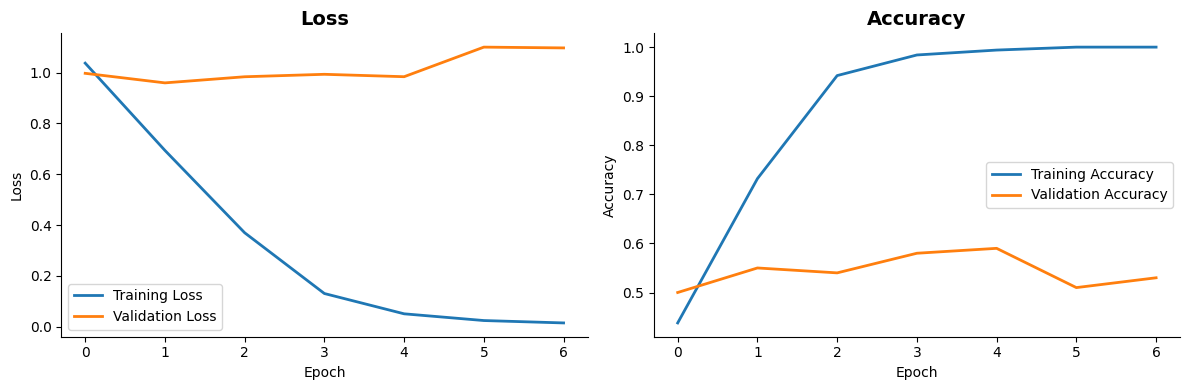

Displaying plot for 0.1 seconds...
Plot closed.
Loading best version of model_layers_1_units_128_dir_bidirectional from models\model_layers_1_units_128_dir_bidirectional.keras for final evaluation.
First layer of loaded_model_for_this_config (model_layers_1_units_128_dir_bidirectional) is: shared_text_vectorizer (type: <class 'keras.src.layers.preprocessing.text_vectorization.TextVectorization'>)
Evaluating model model_layers_1_units_128_dir_bidirectional on test data...
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step
Test Macro F1-Score for model_layers_1_units_128_dir_bidirectional: 0.5300

>>>> CONFIGURATION: layers_2_units_32_dir_unidirectional (RNN Type: SimpleRNN) <<<<

--- Training model: model_layers_2_units_32_dir_unidirectional ---
Model model_layers_2_units_32_dir_unidirectional built with input shape: (None,)


c:\Users\saput\OneDrive\Desktop\Kuliah\Semester 6\ML\CNNxRNN\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "model_layers_2_units_32_dir_unidirectional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ shared_text_vectorizer          │ (None, 120)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 120, 256)       │     5,120,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simplernn_1 (SimpleRNN)         │ (None, 120, 32)        │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simplernn_2 (SimpleRNN)         │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_dense (Dense)            │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,131,427 (19.57 MB)

 Trainable params: 5,131,427 (19.57 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20

Epoch 1: val_loss improved from inf to 1.08283, saving model to models\model_layers_2_units_32_dir_unidirectional.keras
16/16 - 7s - 436ms/step - accuracy: 0.3520 - loss: 1.1252 - val_accuracy: 0.3800 - val_loss: 1.0828
Epoch 2/20

Epoch 2: val_loss did not improve from 1.08283
16/16 - 1s - 71ms/step - accuracy: 0.3840 - loss: 1.1423 - val_accuracy: 0.4500 - val_loss: 1.1162
Epoch 3/20

Epoch 3: val_loss improved from 1.08283 to 1.07202, saving model to models\model_layers_2_units_32_dir_unidirectional.keras
16/16 - 2s - 111ms/step - accuracy: 0.6080 - loss: 0.8980 - val_accuracy: 0.5000 - val_loss: 1.0720
Epoch 4/20

Epoch 4: val_loss did not improve from 1.07202
16/16 - 1s - 70ms/step - accuracy: 0.6260 - loss: 0.8092 - val_accuracy: 0.3800 - val_loss: 1.2399
Epoch 5/20

Epoch 5: val_loss did not improve from 1.07202
16/16 - 1s - 77ms/step - accuracy: 0.8460 - loss: 0.4756 - val_accuracy: 0.4300 - val_loss: 1.3119
Epoch 6/20

Epoch 6: val_loss did not improve from 1.07202

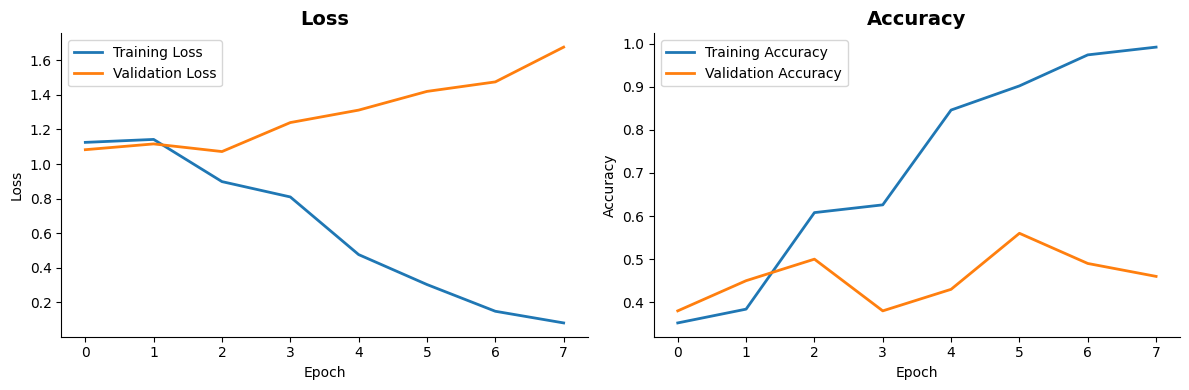

Displaying plot for 0.1 seconds...
Plot closed.
Loading best version of model_layers_2_units_32_dir_unidirectional from models\model_layers_2_units_32_dir_unidirectional.keras for final evaluation.
First layer of loaded_model_for_this_config (model_layers_2_units_32_dir_unidirectional) is: shared_text_vectorizer (type: <class 'keras.src.layers.preprocessing.text_vectorization.TextVectorization'>)
Evaluating model model_layers_2_units_32_dir_unidirectional on test data...
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
Test Macro F1-Score for model_layers_2_units_32_dir_unidirectional: 0.3553

>>>> CONFIGURATION: layers_2_units_32_dir_bidirectional (RNN Type: SimpleRNN) <<<<

--- Training model: model_layers_2_units_32_dir_bidirectional ---
Model model_layers_2_units_32_dir_bidirectional built with input shape: (None,)


c:\Users\saput\OneDrive\Desktop\Kuliah\Semester 6\ML\CNNxRNN\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "model_layers_2_units_32_dir_bidirectional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ shared_text_vectorizer          │ (None, 120)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 120, 256)       │     5,120,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_simplernn_1       │ (None, 120, 64)        │        18,496 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_simplernn_2       │ (None, 64)             │         6,208 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_dense (Dense)            │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,144,899 (19.63 MB)

 Trainable params: 5,144,899 (19.63 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20

Epoch 1: val_loss improved from inf to 1.02264, saving model to models\model_layers_2_units_32_dir_bidirectional.keras
16/16 - 8s - 514ms/step - accuracy: 0.4640 - loss: 1.0704 - val_accuracy: 0.4500 - val_loss: 1.0226
Epoch 2/20

Epoch 2: val_loss improved from 1.02264 to 0.96651, saving model to models\model_layers_2_units_32_dir_bidirectional.keras
16/16 - 2s - 125ms/step - accuracy: 0.7320 - loss: 0.6945 - val_accuracy: 0.4800 - val_loss: 0.9665
Epoch 3/20

Epoch 3: val_loss did not improve from 0.96651
16/16 - 1s - 68ms/step - accuracy: 0.9820 - loss: 0.3433 - val_accuracy: 0.5300 - val_loss: 0.9738
Epoch 4/20

Epoch 4: val_loss did not improve from 0.96651
16/16 - 1s - 66ms/step - accuracy: 0.9960 - loss: 0.1271 - val_accuracy: 0.5100 - val_loss: 1.0372
Epoch 5/20

Epoch 5: val_loss did not improve from 0.96651
16/16 - 1s - 70ms/step - accuracy: 0.9980 - loss: 0.0596 - val_accuracy: 0.5000 - val_loss: 1.0928
Epoch 6/20

Epoch 6: val_loss did not improve from 0.96651
1

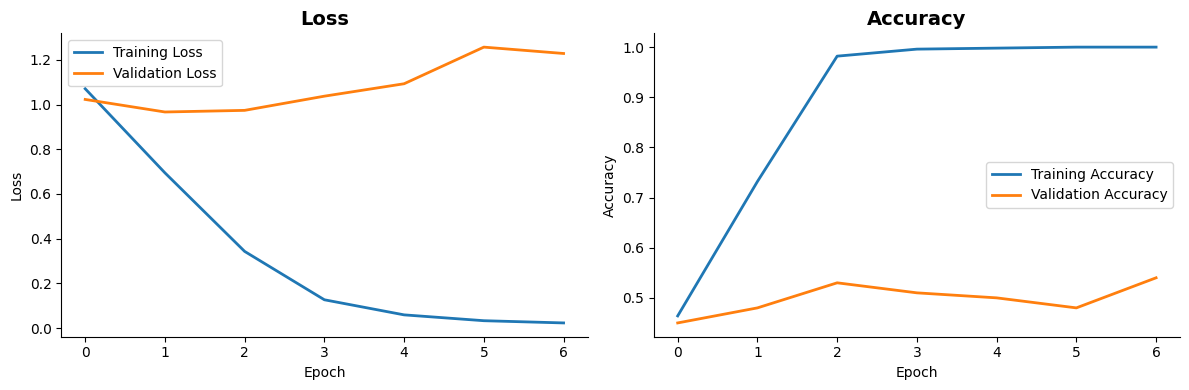

Displaying plot for 0.1 seconds...
Plot closed.
Loading best version of model_layers_2_units_32_dir_bidirectional from models\model_layers_2_units_32_dir_bidirectional.keras for final evaluation.
First layer of loaded_model_for_this_config (model_layers_2_units_32_dir_bidirectional) is: shared_text_vectorizer (type: <class 'keras.src.layers.preprocessing.text_vectorization.TextVectorization'>)
Evaluating model model_layers_2_units_32_dir_bidirectional on test data...
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step
Test Macro F1-Score for model_layers_2_units_32_dir_bidirectional: 0.5084

>>>> CONFIGURATION: layers_2_units_64_dir_unidirectional (RNN Type: SimpleRNN) <<<<

--- Training model: model_layers_2_units_64_dir_unidirectional ---
Model model_layers_2_units_64_dir_unidirectional built with input shape: (None,)


c:\Users\saput\OneDrive\Desktop\Kuliah\Semester 6\ML\CNNxRNN\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "model_layers_2_units_64_dir_unidirectional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ shared_text_vectorizer          │ (None, 120)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 120, 256)       │     5,120,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simplernn_1 (SimpleRNN)         │ (None, 120, 64)        │        20,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simplernn_2 (SimpleRNN)         │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_dense (Dense)            │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,148,995 (19.64 MB)

 Trainable params: 5,148,995 (19.64 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20

Epoch 1: val_loss improved from inf to 1.09284, saving model to models\model_layers_2_units_64_dir_unidirectional.keras
16/16 - 5s - 341ms/step - accuracy: 0.3740 - loss: 1.1937 - val_accuracy: 0.3800 - val_loss: 1.0928
Epoch 2/20

Epoch 2: val_loss improved from 1.09284 to 1.07842, saving model to models\model_layers_2_units_64_dir_unidirectional.keras
16/16 - 2s - 115ms/step - accuracy: 0.3960 - loss: 1.1099 - val_accuracy: 0.4800 - val_loss: 1.0784
Epoch 3/20

Epoch 3: val_loss did not improve from 1.07842
16/16 - 1s - 89ms/step - accuracy: 0.5260 - loss: 1.0144 - val_accuracy: 0.3700 - val_loss: 1.2979
Epoch 4/20

Epoch 4: val_loss did not improve from 1.07842
16/16 - 2s - 99ms/step - accuracy: 0.6140 - loss: 0.8654 - val_accuracy: 0.4300 - val_loss: 1.1487
Epoch 5/20

Epoch 5: val_loss did not improve from 1.07842
16/16 - 1s - 91ms/step - accuracy: 0.7640 - loss: 0.5890 - val_accuracy: 0.3900 - val_loss: 1.5173
Epoch 6/20

Epoch 6: val_loss did not improve from 1.07842

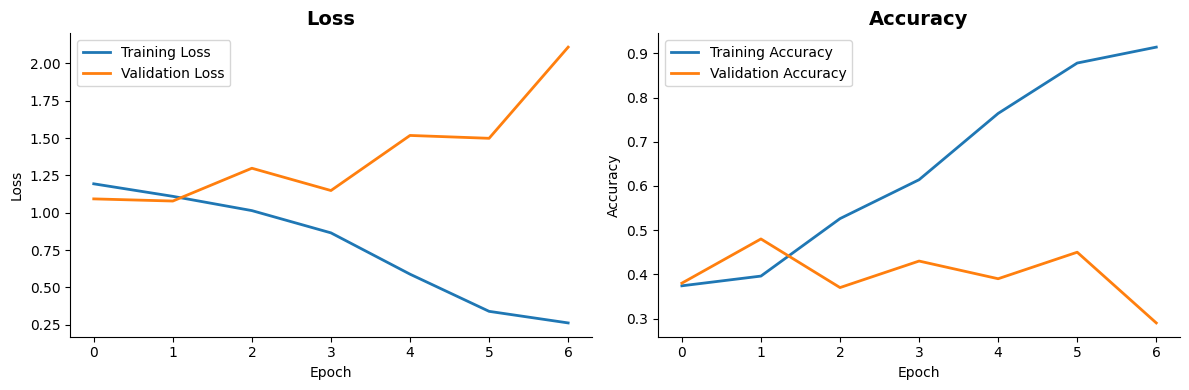

Displaying plot for 0.1 seconds...
Plot closed.
Loading best version of model_layers_2_units_64_dir_unidirectional from models\model_layers_2_units_64_dir_unidirectional.keras for final evaluation.
First layer of loaded_model_for_this_config (model_layers_2_units_64_dir_unidirectional) is: shared_text_vectorizer (type: <class 'keras.src.layers.preprocessing.text_vectorization.TextVectorization'>)
Evaluating model model_layers_2_units_64_dir_unidirectional on test data...
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step
Test Macro F1-Score for model_layers_2_units_64_dir_unidirectional: 0.3721

>>>> CONFIGURATION: layers_2_units_64_dir_bidirectional (RNN Type: SimpleRNN) <<<<

--- Training model: model_layers_2_units_64_dir_bidirectional ---
Model model_layers_2_units_64_dir_bidirectional built with input shape: (None,)


c:\Users\saput\OneDrive\Desktop\Kuliah\Semester 6\ML\CNNxRNN\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "model_layers_2_units_64_dir_bidirectional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ shared_text_vectorizer          │ (None, 120)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 120, 256)       │     5,120,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_simplernn_1       │ (None, 120, 128)       │        41,088 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_simplernn_2       │ (None, 128)            │        24,704 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_dense (Dense)            │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,186,179 (19.78 MB)

 Trainable params: 5,186,179 (19.78 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20

Epoch 1: val_loss improved from inf to 0.97940, saving model to models\model_layers_2_units_64_dir_bidirectional.keras
16/16 - 15s - 950ms/step - accuracy: 0.3820 - loss: 1.1301 - val_accuracy: 0.5000 - val_loss: 0.9794
Epoch 2/20

Epoch 2: val_loss did not improve from 0.97940
16/16 - 5s - 291ms/step - accuracy: 0.8200 - loss: 0.5874 - val_accuracy: 0.4500 - val_loss: 1.0693
Epoch 3/20

Epoch 3: val_loss did not improve from 0.97940
16/16 - 5s - 288ms/step - accuracy: 0.9780 - loss: 0.1755 - val_accuracy: 0.5000 - val_loss: 1.1086
Epoch 4/20

Epoch 4: val_loss did not improve from 0.97940
16/16 - 4s - 280ms/step - accuracy: 0.9960 - loss: 0.0450 - val_accuracy: 0.5300 - val_loss: 1.2375
Epoch 5/20

Epoch 5: val_loss did not improve from 0.97940
16/16 - 4s - 279ms/step - accuracy: 1.0000 - loss: 0.0171 - val_accuracy: 0.4400 - val_loss: 1.4186
Epoch 6/20

Epoch 6: val_loss did not improve from 0.97940
16/16 - 4s - 269ms/step - accuracy: 1.0000 - loss: 0.0085 - val_accuracy:

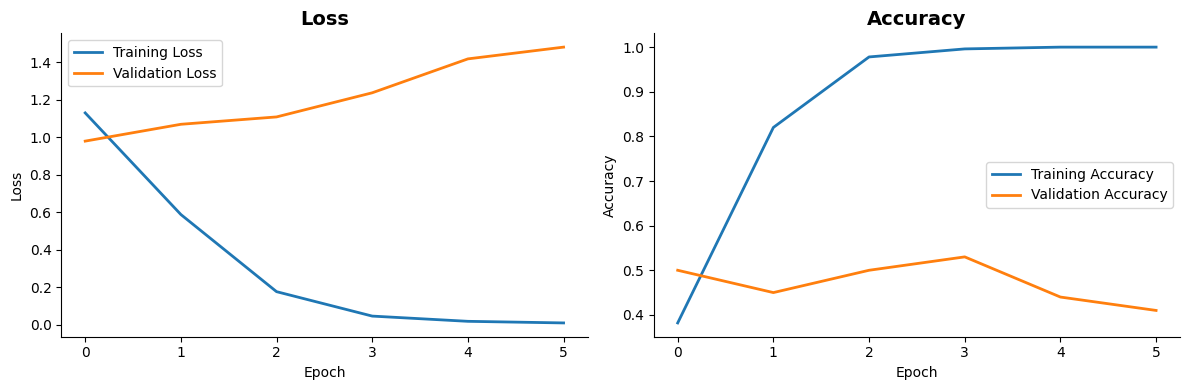

Displaying plot for 0.1 seconds...
Plot closed.
Loading best version of model_layers_2_units_64_dir_bidirectional from models\model_layers_2_units_64_dir_bidirectional.keras for final evaluation.
First layer of loaded_model_for_this_config (model_layers_2_units_64_dir_bidirectional) is: shared_text_vectorizer (type: <class 'keras.src.layers.preprocessing.text_vectorization.TextVectorization'>)
Evaluating model model_layers_2_units_64_dir_bidirectional on test data...
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step
Test Macro F1-Score for model_layers_2_units_64_dir_bidirectional: 0.5052

>>>> CONFIGURATION: layers_2_units_128_dir_unidirectional (RNN Type: SimpleRNN) <<<<

--- Training model: model_layers_2_units_128_dir_unidirectional ---
Model model_layers_2_units_128_dir_unidirectional built with input shape: (None,)


c:\Users\saput\OneDrive\Desktop\Kuliah\Semester 6\ML\CNNxRNN\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "model_layers_2_units_128_dir_unidirectional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ shared_text_vectorizer          │ (None, 120)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 120, 256)       │     5,120,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simplernn_1 (SimpleRNN)         │ (None, 120, 128)       │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simplernn_2 (SimpleRNN)         │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_dense (Dense)            │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,202,563 (19.85 MB)

 Trainable params: 5,202,563 (19.85 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20

Epoch 1: val_loss improved from inf to 1.14846, saving model to models\model_layers_2_units_128_dir_unidirectional.keras
16/16 - 10s - 596ms/step - accuracy: 0.3400 - loss: 1.2138 - val_accuracy: 0.3800 - val_loss: 1.1485
Epoch 2/20

Epoch 2: val_loss did not improve from 1.14846
16/16 - 3s - 167ms/step - accuracy: 0.3440 - loss: 1.1924 - val_accuracy: 0.3800 - val_loss: 1.2440
Epoch 3/20

Epoch 3: val_loss improved from 1.14846 to 1.09737, saving model to models\model_layers_2_units_128_dir_unidirectional.keras
16/16 - 3s - 204ms/step - accuracy: 0.3220 - loss: 1.2212 - val_accuracy: 0.3800 - val_loss: 1.0974
Epoch 4/20

Epoch 4: val_loss did not improve from 1.09737
16/16 - 3s - 164ms/step - accuracy: 0.3380 - loss: 1.1899 - val_accuracy: 0.3800 - val_loss: 1.1050
Epoch 5/20

Epoch 5: val_loss improved from 1.09737 to 1.08680, saving model to models\model_layers_2_units_128_dir_unidirectional.keras
16/16 - 3s - 199ms/step - accuracy: 0.3460 - loss: 1.1800 - val_accuracy: 

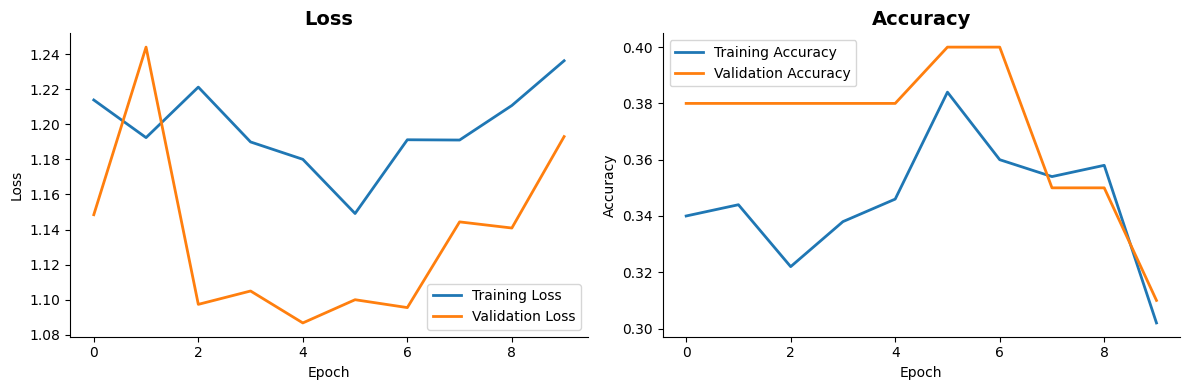

Displaying plot for 0.1 seconds...
Plot closed.
Loading best version of model_layers_2_units_128_dir_unidirectional from models\model_layers_2_units_128_dir_unidirectional.keras for final evaluation.
First layer of loaded_model_for_this_config (model_layers_2_units_128_dir_unidirectional) is: shared_text_vectorizer (type: <class 'keras.src.layers.preprocessing.text_vectorization.TextVectorization'>)
Evaluating model model_layers_2_units_128_dir_unidirectional on test data...
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step
Test Macro F1-Score for model_layers_2_units_128_dir_unidirectional: 0.1827

>>>> CONFIGURATION: layers_2_units_128_dir_bidirectional (RNN Type: SimpleRNN) <<<<

--- Training model: model_layers_2_units_128_dir_bidirectional ---
Model model_layers_2_units_128_dir_bidirectional built with input shape: (None,)


c:\Users\saput\OneDrive\Desktop\Kuliah\Semester 6\ML\CNNxRNN\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "model_layers_2_units_128_dir_bidirectional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ shared_text_vectorizer          │ (None, 120)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 120, 256)       │     5,120,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_simplernn_1       │ (None, 120, 256)       │        98,560 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_simplernn_2       │ (None, 256)            │        98,560 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_dense (Dense)            │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,317,891 (20.29 MB)

 Trainable params: 5,317,891 (20.29 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20

Epoch 1: val_loss improved from inf to 1.07496, saving model to models\model_layers_2_units_128_dir_bidirectional.keras
16/16 - 13s - 840ms/step - accuracy: 0.4520 - loss: 1.0958 - val_accuracy: 0.4500 - val_loss: 1.0750
Epoch 2/20

Epoch 2: val_loss improved from 1.07496 to 1.01999, saving model to models\model_layers_2_units_128_dir_bidirectional.keras
16/16 - 3s - 201ms/step - accuracy: 0.8320 - loss: 0.5105 - val_accuracy: 0.4500 - val_loss: 1.0200
Epoch 3/20

Epoch 3: val_loss did not improve from 1.01999
16/16 - 3s - 164ms/step - accuracy: 0.9920 - loss: 0.0934 - val_accuracy: 0.4500 - val_loss: 1.2636
Epoch 4/20

Epoch 4: val_loss did not improve from 1.01999
16/16 - 3s - 160ms/step - accuracy: 1.0000 - loss: 0.0109 - val_accuracy: 0.4700 - val_loss: 1.3435
Epoch 5/20

Epoch 5: val_loss did not improve from 1.01999
16/16 - 3s - 165ms/step - accuracy: 1.0000 - loss: 0.0039 - val_accuracy: 0.5000 - val_loss: 1.3776
Epoch 6/20

Epoch 6: val_loss did not improve from 1.0

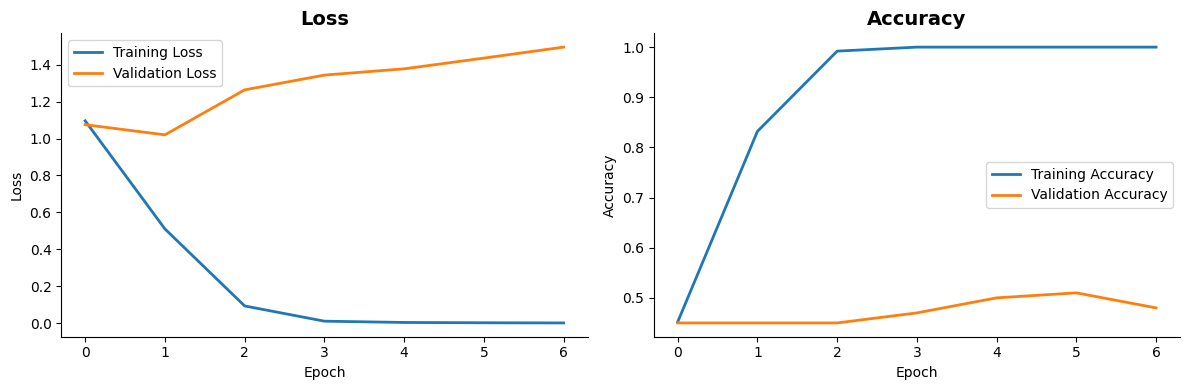

Displaying plot for 0.1 seconds...
Plot closed.
Loading best version of model_layers_2_units_128_dir_bidirectional from models\model_layers_2_units_128_dir_bidirectional.keras for final evaluation.
First layer of loaded_model_for_this_config (model_layers_2_units_128_dir_bidirectional) is: shared_text_vectorizer (type: <class 'keras.src.layers.preprocessing.text_vectorization.TextVectorization'>)
Evaluating model model_layers_2_units_128_dir_bidirectional on test data...
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step
Test Macro F1-Score for model_layers_2_units_128_dir_bidirectional: 0.5358

>>>> CONFIGURATION: layers_3_units_32_dir_unidirectional (RNN Type: SimpleRNN) <<<<

--- Training model: model_layers_3_units_32_dir_unidirectional ---
Model model_layers_3_units_32_dir_unidirectional built with input shape: (None,)


c:\Users\saput\OneDrive\Desktop\Kuliah\Semester 6\ML\CNNxRNN\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "model_layers_3_units_32_dir_unidirectional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ shared_text_vectorizer          │ (None, 120)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 120, 256)       │     5,120,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simplernn_1 (SimpleRNN)         │ (None, 120, 32)        │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simplernn_2 (SimpleRNN)         │ (None, 120, 32)        │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simplernn_3 (SimpleRNN)         │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_dense (Dense)            │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,133,507 (19.58 MB)

 Trainable params: 5,133,507 (19.58 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20

Epoch 1: val_loss improved from inf to 1.11601, saving model to models\model_layers_3_units_32_dir_unidirectional.keras
16/16 - 10s - 626ms/step - accuracy: 0.3640 - loss: 1.2019 - val_accuracy: 0.3800 - val_loss: 1.1160
Epoch 2/20

Epoch 2: val_loss improved from 1.11601 to 1.09561, saving model to models\model_layers_3_units_32_dir_unidirectional.keras
16/16 - 2s - 149ms/step - accuracy: 0.3600 - loss: 1.2013 - val_accuracy: 0.3800 - val_loss: 1.0956
Epoch 3/20

Epoch 3: val_loss did not improve from 1.09561
16/16 - 2s - 112ms/step - accuracy: 0.5160 - loss: 1.0351 - val_accuracy: 0.3400 - val_loss: 1.3102
Epoch 4/20

Epoch 4: val_loss did not improve from 1.09561
16/16 - 2s - 111ms/step - accuracy: 0.7680 - loss: 0.6323 - val_accuracy: 0.3400 - val_loss: 1.8424
Epoch 5/20

Epoch 5: val_loss did not improve from 1.09561
16/16 - 2s - 109ms/step - accuracy: 0.8480 - loss: 0.4247 - val_accuracy: 0.3700 - val_loss: 2.0235
Epoch 6/20

Epoch 6: val_loss did not improve from 1.0

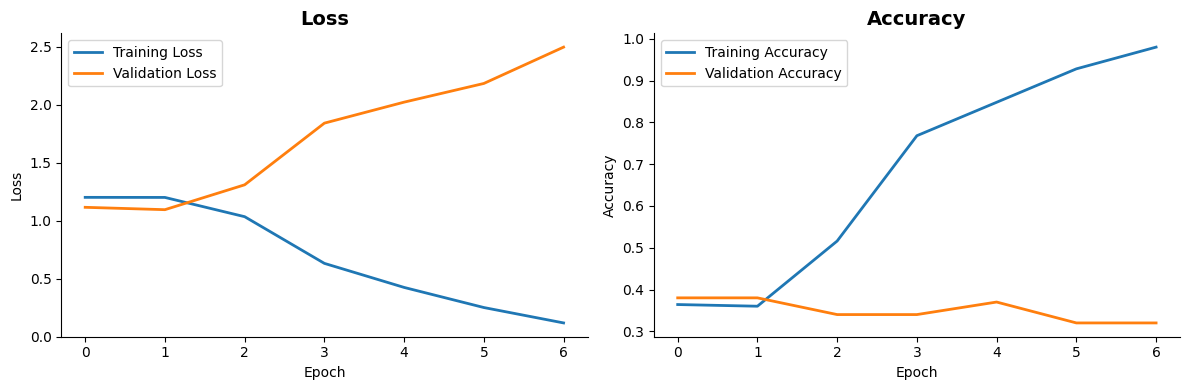

Displaying plot for 0.1 seconds...
Plot closed.
Loading best version of model_layers_3_units_32_dir_unidirectional from models\model_layers_3_units_32_dir_unidirectional.keras for final evaluation.
First layer of loaded_model_for_this_config (model_layers_3_units_32_dir_unidirectional) is: shared_text_vectorizer (type: <class 'keras.src.layers.preprocessing.text_vectorization.TextVectorization'>)
Evaluating model model_layers_3_units_32_dir_unidirectional on test data...
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step
Test Macro F1-Score for model_layers_3_units_32_dir_unidirectional: 0.1844

>>>> CONFIGURATION: layers_3_units_32_dir_bidirectional (RNN Type: SimpleRNN) <<<<

--- Training model: model_layers_3_units_32_dir_bidirectional ---


c:\Users\saput\OneDrive\Desktop\Kuliah\Semester 6\ML\CNNxRNN\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model model_layers_3_units_32_dir_bidirectional built with input shape: (None,)


Model: "model_layers_3_units_32_dir_bidirectional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ shared_text_vectorizer          │ (None, 120)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 120, 256)       │     5,120,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_simplernn_1       │ (None, 120, 64)        │        18,496 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_simplernn_2       │ (None, 120, 64)        │         6,208 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_simplernn_3       │ (None, 64)             │         6,208 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_dense (Dense)            │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,151,107 (19.65 MB)

 Trainable params: 5,151,107 (19.65 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20

Epoch 1: val_loss improved from inf to 1.07791, saving model to models\model_layers_3_units_32_dir_bidirectional.keras
16/16 - 19s - 1s/step - accuracy: 0.3920 - loss: 1.1372 - val_accuracy: 0.4300 - val_loss: 1.0779
Epoch 2/20

Epoch 2: val_loss improved from 1.07791 to 1.02762, saving model to models\model_layers_3_units_32_dir_bidirectional.keras
16/16 - 5s - 285ms/step - accuracy: 0.7840 - loss: 0.6329 - val_accuracy: 0.5100 - val_loss: 1.0276
Epoch 3/20

Epoch 3: val_loss did not improve from 1.02762
16/16 - 4s - 237ms/step - accuracy: 0.9700 - loss: 0.2608 - val_accuracy: 0.4700 - val_loss: 1.1169
Epoch 4/20

Epoch 4: val_loss did not improve from 1.02762
16/16 - 4s - 224ms/step - accuracy: 0.9980 - loss: 0.0908 - val_accuracy: 0.4600 - val_loss: 1.2243
Epoch 5/20

Epoch 5: val_loss did not improve from 1.02762
16/16 - 4s - 225ms/step - accuracy: 1.0000 - loss: 0.0392 - val_accuracy: 0.4500 - val_loss: 1.3405
Epoch 6/20

Epoch 6: val_loss did not improve from 1.02762


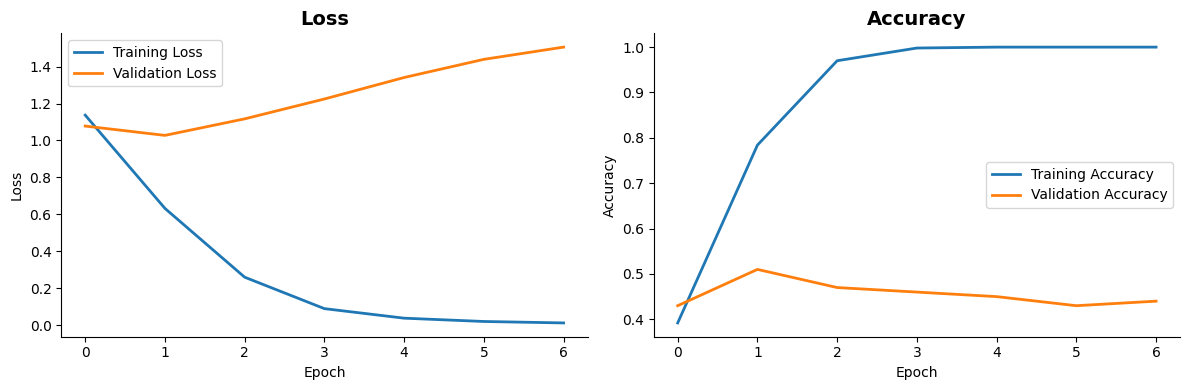

Displaying plot for 0.1 seconds...
Plot closed.
Loading best version of model_layers_3_units_32_dir_bidirectional from models\model_layers_3_units_32_dir_bidirectional.keras for final evaluation.
First layer of loaded_model_for_this_config (model_layers_3_units_32_dir_bidirectional) is: shared_text_vectorizer (type: <class 'keras.src.layers.preprocessing.text_vectorization.TextVectorization'>)
Evaluating model model_layers_3_units_32_dir_bidirectional on test data...
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 179ms/step
Test Macro F1-Score for model_layers_3_units_32_dir_bidirectional: 0.4234

>>>> CONFIGURATION: layers_3_units_64_dir_unidirectional (RNN Type: SimpleRNN) <<<<

--- Training model: model_layers_3_units_64_dir_unidirectional ---
Model model_layers_3_units_64_dir_unidirectional built with input shape: (None,)


c:\Users\saput\OneDrive\Desktop\Kuliah\Semester 6\ML\CNNxRNN\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "model_layers_3_units_64_dir_unidirectional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ shared_text_vectorizer          │ (None, 120)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 120, 256)       │     5,120,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simplernn_1 (SimpleRNN)         │ (None, 120, 64)        │        20,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simplernn_2 (SimpleRNN)         │ (None, 120, 64)        │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simplernn_3 (SimpleRNN)         │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_dense (Dense)            │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,157,251 (19.67 MB)

 Trainable params: 5,157,251 (19.67 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20

Epoch 1: val_loss improved from inf to 1.13325, saving model to models\model_layers_3_units_64_dir_unidirectional.keras
16/16 - 11s - 705ms/step - accuracy: 0.3320 - loss: 1.2544 - val_accuracy: 0.3800 - val_loss: 1.1332
Epoch 2/20

Epoch 2: val_loss did not improve from 1.13325
16/16 - 3s - 161ms/step - accuracy: 0.3740 - loss: 1.1835 - val_accuracy: 0.3800 - val_loss: 1.1691
Epoch 3/20

Epoch 3: val_loss improved from 1.13325 to 1.08331, saving model to models\model_layers_3_units_64_dir_unidirectional.keras
16/16 - 3s - 180ms/step - accuracy: 0.3400 - loss: 1.2130 - val_accuracy: 0.3800 - val_loss: 1.0833
Epoch 4/20

Epoch 4: val_loss did not improve from 1.08331
16/16 - 2s - 148ms/step - accuracy: 0.3100 - loss: 1.2022 - val_accuracy: 0.3800 - val_loss: 1.0836
Epoch 5/20

Epoch 5: val_loss did not improve from 1.08331
16/16 - 2s - 146ms/step - accuracy: 0.3580 - loss: 1.1570 - val_accuracy: 0.3800 - val_loss: 1.0926
Epoch 6/20

Epoch 6: val_loss did not improve from 1.0

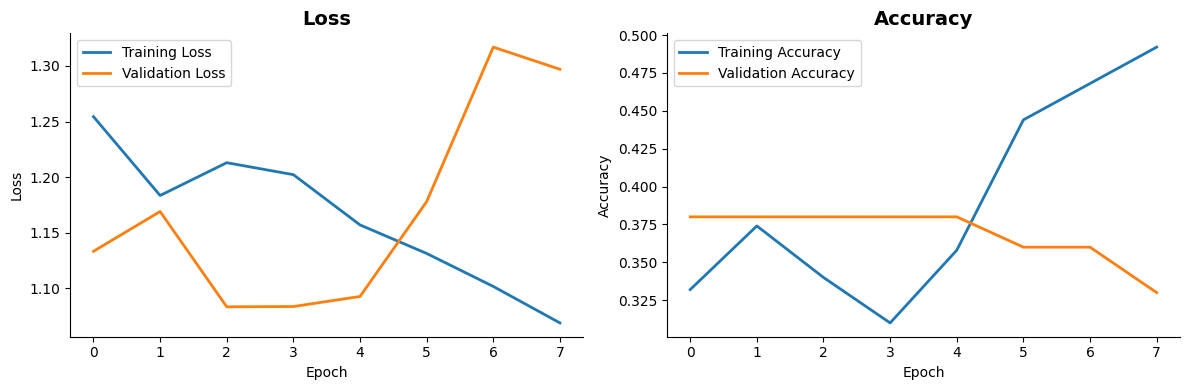

Displaying plot for 0.1 seconds...
Plot closed.
Loading best version of model_layers_3_units_64_dir_unidirectional from models\model_layers_3_units_64_dir_unidirectional.keras for final evaluation.
First layer of loaded_model_for_this_config (model_layers_3_units_64_dir_unidirectional) is: shared_text_vectorizer (type: <class 'keras.src.layers.preprocessing.text_vectorization.TextVectorization'>)
Evaluating model model_layers_3_units_64_dir_unidirectional on test data...
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step
Test Macro F1-Score for model_layers_3_units_64_dir_unidirectional: 0.1827

>>>> CONFIGURATION: layers_3_units_64_dir_bidirectional (RNN Type: SimpleRNN) <<<<

--- Training model: model_layers_3_units_64_dir_bidirectional ---


c:\Users\saput\OneDrive\Desktop\Kuliah\Semester 6\ML\CNNxRNN\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model model_layers_3_units_64_dir_bidirectional built with input shape: (None,)


Model: "model_layers_3_units_64_dir_bidirectional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ shared_text_vectorizer          │ (None, 120)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 120, 256)       │     5,120,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_simplernn_1       │ (None, 120, 128)       │        41,088 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_simplernn_2       │ (None, 120, 128)       │        24,704 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_simplernn_3       │ (None, 128)            │        24,704 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_dense (Dense)            │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,210,883 (19.88 MB)

 Trainable params: 5,210,883 (19.88 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20

Epoch 1: val_loss improved from inf to 0.99282, saving model to models\model_layers_3_units_64_dir_bidirectional.keras
16/16 - 17s - 1s/step - accuracy: 0.4680 - loss: 1.0862 - val_accuracy: 0.4900 - val_loss: 0.9928
Epoch 2/20

Epoch 2: val_loss did not improve from 0.99282
16/16 - 3s - 216ms/step - accuracy: 0.7560 - loss: 0.6164 - val_accuracy: 0.4800 - val_loss: 1.0463
Epoch 3/20

Epoch 3: val_loss did not improve from 0.99282
16/16 - 3s - 195ms/step - accuracy: 0.9620 - loss: 0.1779 - val_accuracy: 0.4700 - val_loss: 1.2500
Epoch 4/20

Epoch 4: val_loss did not improve from 0.99282
16/16 - 3s - 191ms/step - accuracy: 0.9960 - loss: 0.0515 - val_accuracy: 0.4800 - val_loss: 1.3120
Epoch 5/20

Epoch 5: val_loss did not improve from 0.99282
16/16 - 3s - 194ms/step - accuracy: 1.0000 - loss: 0.0202 - val_accuracy: 0.5100 - val_loss: 1.3267
Epoch 6/20

Epoch 6: val_loss did not improve from 0.99282
16/16 - 3s - 195ms/step - accuracy: 1.0000 - loss: 0.0139 - val_accuracy: 0.

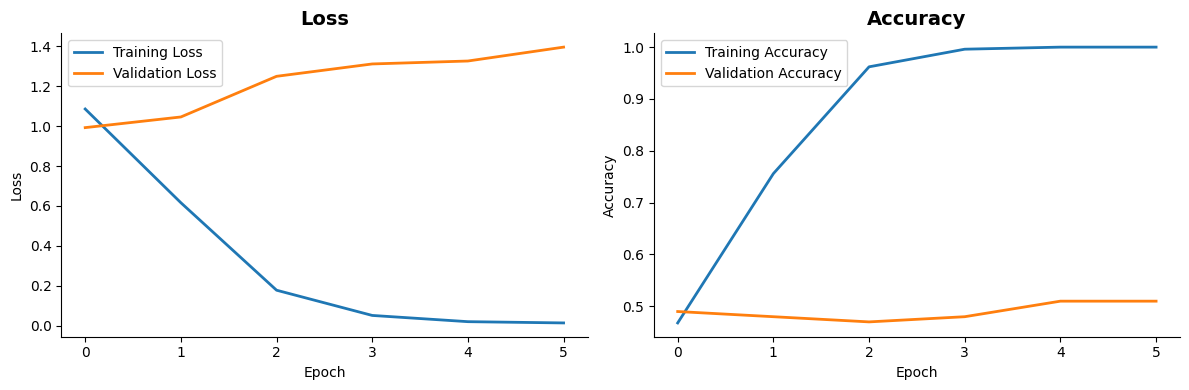

Displaying plot for 0.1 seconds...
Plot closed.
Loading best version of model_layers_3_units_64_dir_bidirectional from models\model_layers_3_units_64_dir_bidirectional.keras for final evaluation.
First layer of loaded_model_for_this_config (model_layers_3_units_64_dir_bidirectional) is: shared_text_vectorizer (type: <class 'keras.src.layers.preprocessing.text_vectorization.TextVectorization'>)
Evaluating model model_layers_3_units_64_dir_bidirectional on test data...
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 188ms/step
Test Macro F1-Score for model_layers_3_units_64_dir_bidirectional: 0.4106

>>>> CONFIGURATION: layers_3_units_128_dir_unidirectional (RNN Type: SimpleRNN) <<<<

--- Training model: model_layers_3_units_128_dir_unidirectional ---
Model model_layers_3_units_128_dir_unidirectional built with input shape: (None,)


c:\Users\saput\OneDrive\Desktop\Kuliah\Semester 6\ML\CNNxRNN\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "model_layers_3_units_128_dir_unidirectional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ shared_text_vectorizer          │ (None, 120)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 120, 256)       │     5,120,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simplernn_1 (SimpleRNN)         │ (None, 120, 128)       │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simplernn_2 (SimpleRNN)         │ (None, 120, 128)       │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simplernn_3 (SimpleRNN)         │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_dense (Dense)            │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,235,459 (19.97 MB)

 Trainable params: 5,235,459 (19.97 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20

Epoch 1: val_loss improved from inf to 1.08895, saving model to models\model_layers_3_units_128_dir_unidirectional.keras
16/16 - 11s - 658ms/step - accuracy: 0.3920 - loss: 1.2324 - val_accuracy: 0.3800 - val_loss: 1.0890
Epoch 2/20

Epoch 2: val_loss did not improve from 1.08895
16/16 - 2s - 140ms/step - accuracy: 0.3740 - loss: 1.1889 - val_accuracy: 0.3800 - val_loss: 1.1354
Epoch 3/20

Epoch 3: val_loss did not improve from 1.08895
16/16 - 2s - 141ms/step - accuracy: 0.3620 - loss: 1.2228 - val_accuracy: 0.3800 - val_loss: 1.1516
Epoch 4/20

Epoch 4: val_loss did not improve from 1.08895
16/16 - 2s - 139ms/step - accuracy: 0.3480 - loss: 1.2269 - val_accuracy: 0.3800 - val_loss: 1.1337
Epoch 5/20

Epoch 5: val_loss improved from 1.08895 to 1.08108, saving model to models\model_layers_3_units_128_dir_unidirectional.keras
16/16 - 3s - 159ms/step - accuracy: 0.3660 - loss: 1.1792 - val_accuracy: 0.3800 - val_loss: 1.0811
Epoch 6/20

Epoch 6: val_loss did not improve from 1

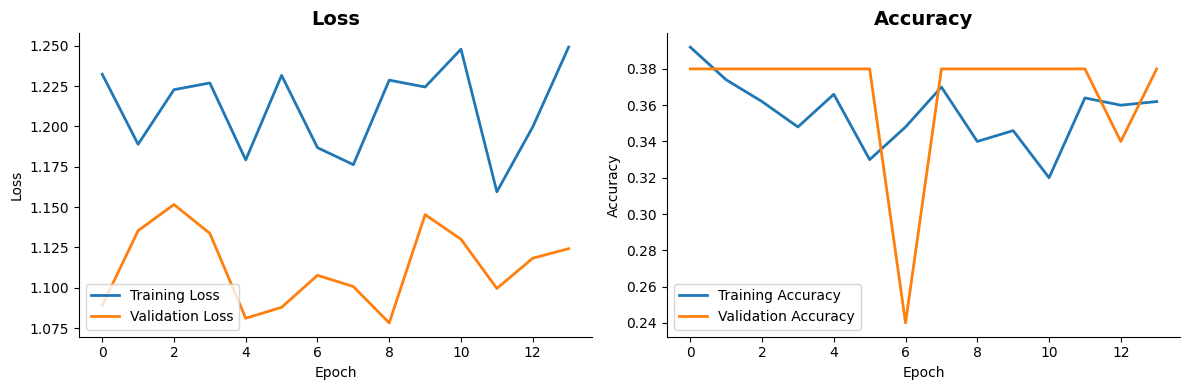

Displaying plot for 0.1 seconds...
Plot closed.
Loading best version of model_layers_3_units_128_dir_unidirectional from models\model_layers_3_units_128_dir_unidirectional.keras for final evaluation.
First layer of loaded_model_for_this_config (model_layers_3_units_128_dir_unidirectional) is: shared_text_vectorizer (type: <class 'keras.src.layers.preprocessing.text_vectorization.TextVectorization'>)
Evaluating model model_layers_3_units_128_dir_unidirectional on test data...
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step
Test Macro F1-Score for model_layers_3_units_128_dir_unidirectional: 0.1844

>>>> CONFIGURATION: layers_3_units_128_dir_bidirectional (RNN Type: SimpleRNN) <<<<

--- Training model: model_layers_3_units_128_dir_bidirectional ---


c:\Users\saput\OneDrive\Desktop\Kuliah\Semester 6\ML\CNNxRNN\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model model_layers_3_units_128_dir_bidirectional built with input shape: (None,)


Model: "model_layers_3_units_128_dir_bidirectional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ shared_text_vectorizer          │ (None, 120)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 120, 256)       │     5,120,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_simplernn_1       │ (None, 120, 256)       │        98,560 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_simplernn_2       │ (None, 120, 256)       │        98,560 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_simplernn_3       │ (None, 256)            │        98,560 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_dense (Dense)            │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,416,451 (20.66 MB)

 Trainable params: 5,416,451 (20.66 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20

Epoch 1: val_loss improved from inf to 1.30244, saving model to models\model_layers_3_units_128_dir_bidirectional.keras
16/16 - 18s - 1s/step - accuracy: 0.3620 - loss: 1.3092 - val_accuracy: 0.3700 - val_loss: 1.3024
Epoch 2/20

Epoch 2: val_loss improved from 1.30244 to 1.13405, saving model to models\model_layers_3_units_128_dir_bidirectional.keras
16/16 - 6s - 360ms/step - accuracy: 0.3540 - loss: 1.2861 - val_accuracy: 0.3800 - val_loss: 1.1341
Epoch 3/20

Epoch 3: val_loss improved from 1.13405 to 1.04612, saving model to models\model_layers_3_units_128_dir_bidirectional.keras
16/16 - 6s - 369ms/step - accuracy: 0.3960 - loss: 1.2187 - val_accuracy: 0.4400 - val_loss: 1.0461
Epoch 4/20

Epoch 4: val_loss did not improve from 1.04612
16/16 - 5s - 315ms/step - accuracy: 0.5340 - loss: 0.9910 - val_accuracy: 0.4300 - val_loss: 1.0847
Epoch 5/20

Epoch 5: val_loss did not improve from 1.04612
16/16 - 5s - 316ms/step - accuracy: 0.8840 - loss: 0.3245 - val_accuracy: 0.5200

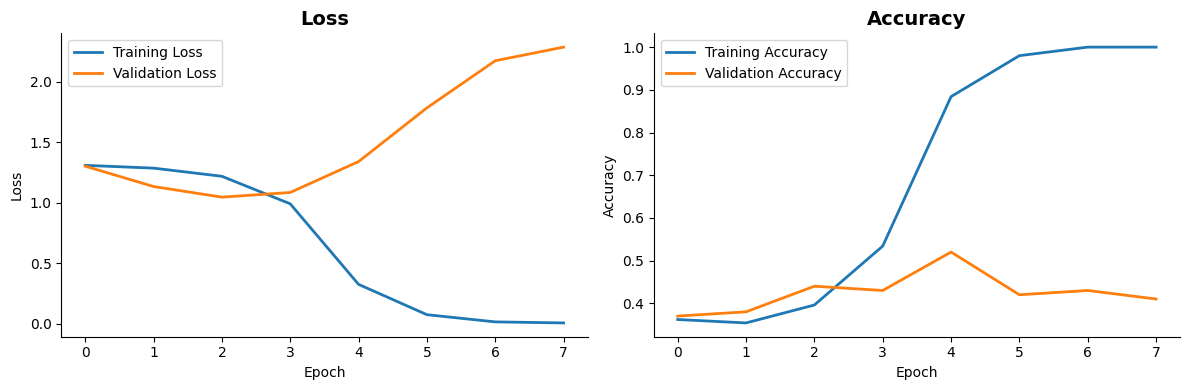

Displaying plot for 0.1 seconds...
Plot closed.
Loading best version of model_layers_3_units_128_dir_bidirectional from models\model_layers_3_units_128_dir_bidirectional.keras for final evaluation.
First layer of loaded_model_for_this_config (model_layers_3_units_128_dir_bidirectional) is: shared_text_vectorizer (type: <class 'keras.src.layers.preprocessing.text_vectorization.TextVectorization'>)
Evaluating model model_layers_3_units_128_dir_bidirectional on test data...
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 198ms/step
Test Macro F1-Score for model_layers_3_units_128_dir_bidirectional: 0.3670

--- Hyperparameter Sweep Results ---
Config: layers_1_units_64_dir_bidirectional           | RNN Type: SimpleRNN  | Macro F1: 0.5920
Config: layers_1_units_32_dir_bidirectional           | RNN Type: SimpleRNN  | Macro F1: 0.5368
Config: layers_2_units_128_dir_bidirectional          | RNN Type: SimpleRNN  | Macro F1: 0.5358
Config: layers_1_units_128_dir_bidirectional          | RNN Type: SimpleRNN  | Mac

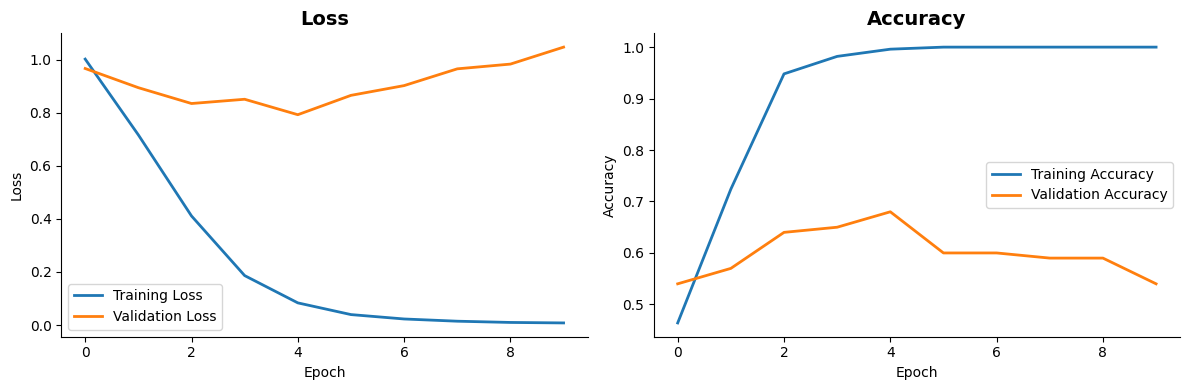

Displaying plot for 0.1 seconds...
Plot closed.
Saved metrics plot for best 1 layer(s) (config: layers_1_units_64_dir_bidirectional, F1: 0.5920) as metrics_curves_Best_1_layer_f1.png
Final Training Loss: 0.0014
Final Training Accuracy: 1.0000
Final Validation Loss: 1.4951
Final Validation Accuracy: 0.4800
Metrics curves (Loss and Accuracy) saved to plots\metrics_curves_Best_2_layer_f1.png


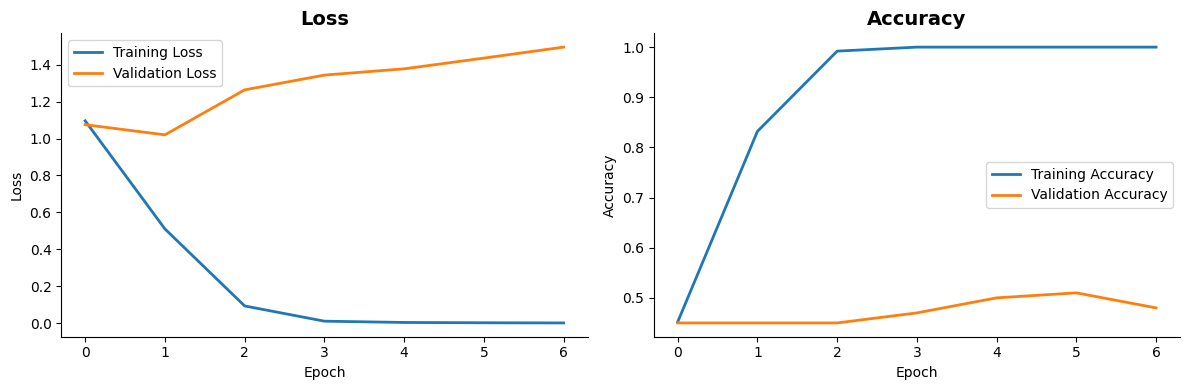

Displaying plot for 0.1 seconds...
Plot closed.
Saved metrics plot for best 2 layer(s) (config: layers_2_units_128_dir_bidirectional, F1: 0.5358) as metrics_curves_Best_2_layer_f1.png
Final Training Loss: 0.0135
Final Training Accuracy: 1.0000
Final Validation Loss: 1.5048
Final Validation Accuracy: 0.4400
Metrics curves (Loss and Accuracy) saved to plots\metrics_curves_Best_3_layer_f1.png


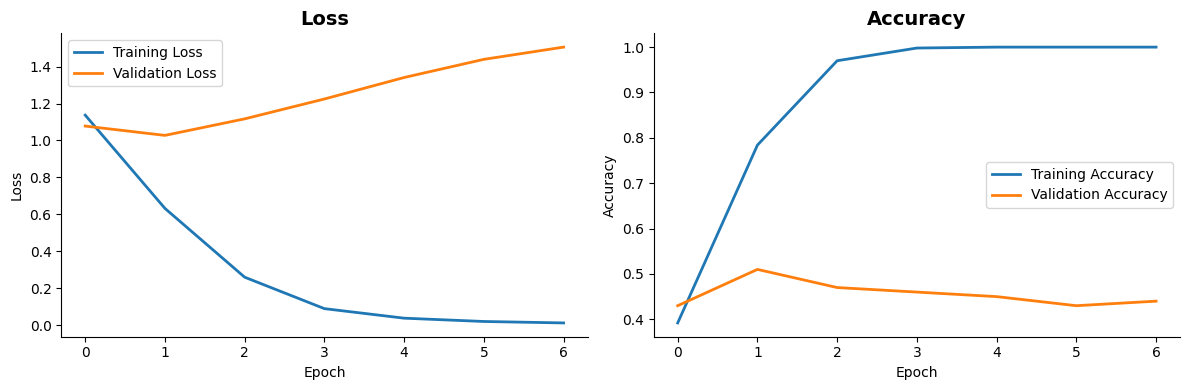

Displaying plot for 0.1 seconds...
Plot closed.
Saved metrics plot for best 3 layer(s) (config: layers_3_units_32_dir_bidirectional, F1: 0.4234) as metrics_curves_Best_3_layer_f1.png
Final Training Loss: 0.0295
Final Training Accuracy: 1.0000
Final Validation Loss: 0.9168
Final Validation Accuracy: 0.6000
Metrics curves (Loss and Accuracy) saved to plots\metrics_curves_Best_32_units_f1.png


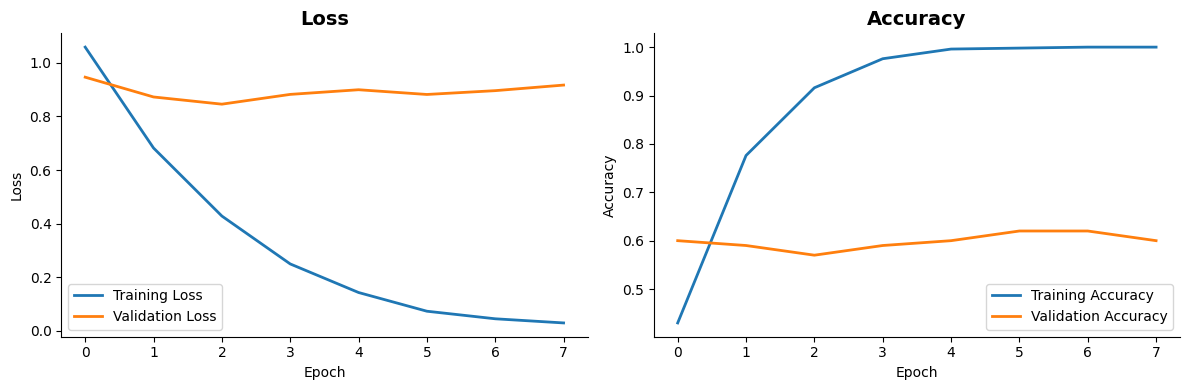

Displaying plot for 0.1 seconds...
Plot closed.
Saved metrics plot for best 32 units (config: layers_1_units_32_dir_bidirectional, F1: 0.5368) as metrics_curves_Best_32_units_f1.png
Final Training Loss: 0.0079
Final Training Accuracy: 1.0000
Final Validation Loss: 1.0472
Final Validation Accuracy: 0.5400
Metrics curves (Loss and Accuracy) saved to plots\metrics_curves_Best_64_units_f1.png


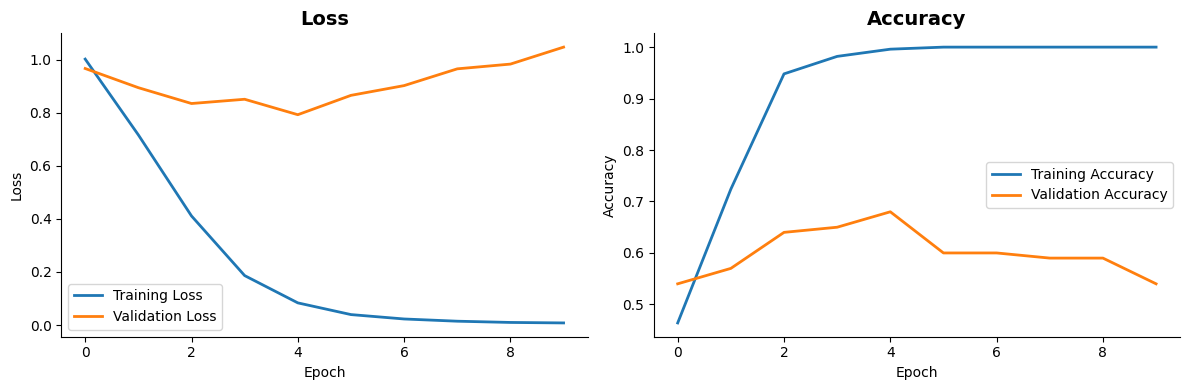

Displaying plot for 0.1 seconds...
Plot closed.
Saved metrics plot for best 64 units (config: layers_1_units_64_dir_bidirectional, F1: 0.5920) as metrics_curves_Best_64_units_f1.png
Final Training Loss: 0.0014
Final Training Accuracy: 1.0000
Final Validation Loss: 1.4951
Final Validation Accuracy: 0.4800
Metrics curves (Loss and Accuracy) saved to plots\metrics_curves_Best_128_units_f1.png


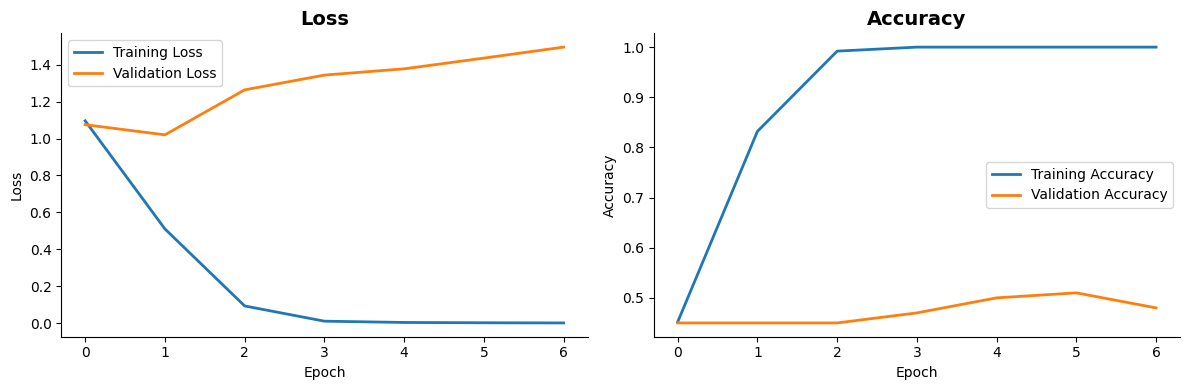

Displaying plot for 0.1 seconds...
Plot closed.
Saved metrics plot for best 128 units (config: layers_2_units_128_dir_bidirectional, F1: 0.5358) as metrics_curves_Best_128_units_f1.png
Final Training Loss: 0.2627
Final Training Accuracy: 0.9140
Final Validation Loss: 2.1084
Final Validation Accuracy: 0.2900
Metrics curves (Loss and Accuracy) saved to plots\metrics_curves_Best_unidirectional_f1.png


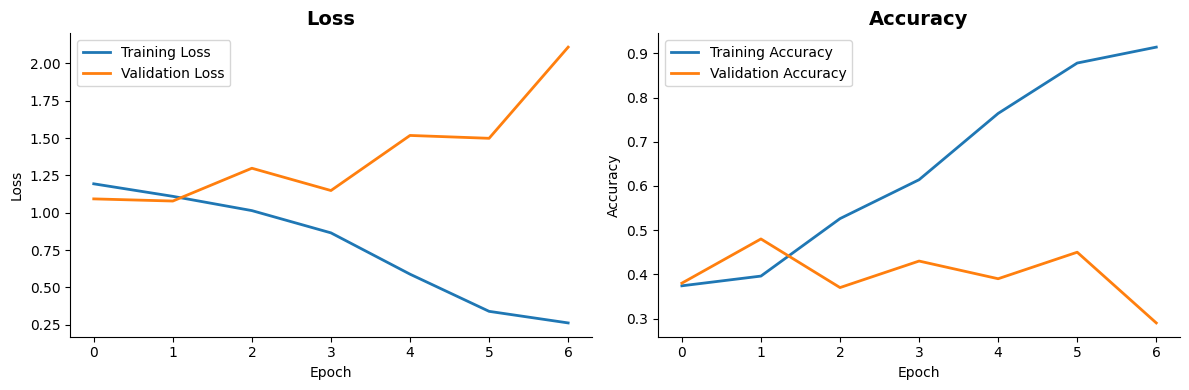

Displaying plot for 0.1 seconds...
Plot closed.
Saved metrics plot for best unidirectional RNN (config: layers_2_units_64_dir_unidirectional, F1: 0.3721) as metrics_curves_Best_unidirectional_f1.png
Final Training Loss: 0.0079
Final Training Accuracy: 1.0000
Final Validation Loss: 1.0472
Final Validation Accuracy: 0.5400
Metrics curves (Loss and Accuracy) saved to plots\metrics_curves_Best_bidirectional_f1.png


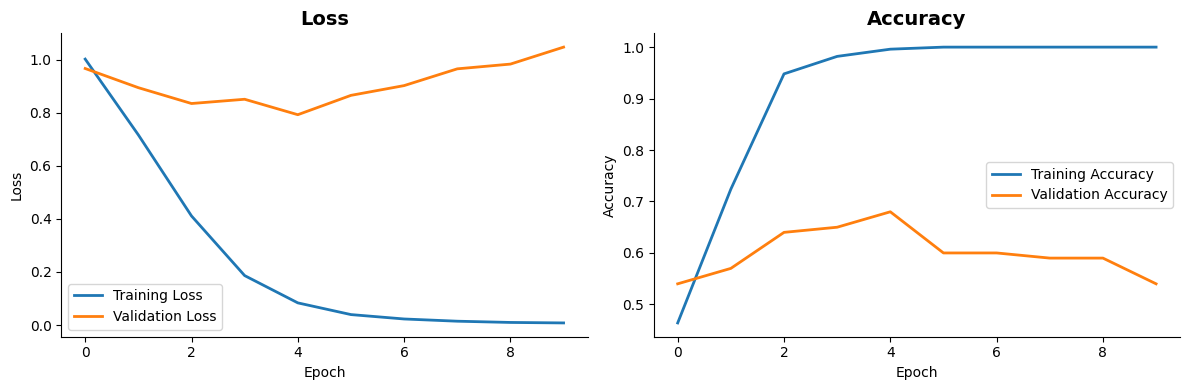

Displaying plot for 0.1 seconds...
Plot closed.
Saved metrics plot for best bidirectional RNN (config: layers_1_units_64_dir_bidirectional, F1: 0.5920) as metrics_curves_Best_bidirectional_f1.png
Hyperparameter sweep summary saved to plots\hyperparameter_sweep_summary.json
Training pipeline finished.
Training pipeline call finished. Check console output for details.


In [7]:
print("Attempting to run training pipeline...")
main_function(['--train'])
print("Training pipeline call finished. Check console output for details.")

### 7.2 Run From-Scratch Test (Specific Configuration)

In [8]:
model_config_to_test = 'best_model'
print(f"Attempting to run from-scratch test for: {model_config_to_test}...")
main_function(['--test-scratch', model_config_to_test, '--inference-batch-size', '32'])
print(f"From-scratch test call for {model_config_to_test} finished. Check console output.")

Attempting to run from-scratch test for: best_model...
Starting from-scratch test for: best_model

--- Running From-Scratch Test for model: best_model ---
--- Using inference batch size for scratch model: 32 ---
Loading Keras model from: models\best_model.keras
TextVectorization layer successfully retrieved from the loaded Keras model.
Number of classes detected from Keras model's last layer: 3
Loaded 500 samples from data/train.csv. Label mapping: {'negative': np.int64(0), 'neutral': np.int64(1), 'positive': np.int64(2)}
Loaded 100 samples from data/valid.csv. Label mapping: {'negative': np.int64(0), 'neutral': np.int64(1), 'positive': np.int64(2)}
Loaded 400 samples from data/test.csv. Label mapping: {'negative': np.int64(0), 'neutral': np.int64(1), 'positive': np.int64(2)}
Vectorizing test texts using the Keras model's TextVectorization layer...
Shape of vectorized test data (NumPy): (400, 120)
Loaded configuration for 'best_model' from JSON: Layers=1, Units=64, Direction=bidirectio

### 7.3 Run From-Scratch Test (Best Model with Backward Pass)

In [9]:
print("Attempting to run from-scratch test for 'best_model' with backward pass demo...")
main_function(['--test-scratch', 'best_model', '--demo-backward', '--inference-batch-size', '16'])
print("From-scratch test call for 'best_model' finished. Check console output.")

Attempting to run from-scratch test for 'best_model' with backward pass demo...
Starting from-scratch test for: best_model

--- Running From-Scratch Test for model: best_model ---
--- Using inference batch size for scratch model: 16 ---
Loading Keras model from: models\best_model.keras
TextVectorization layer successfully retrieved from the loaded Keras model.
Number of classes detected from Keras model's last layer: 3
Loaded 500 samples from data/train.csv. Label mapping: {'negative': np.int64(0), 'neutral': np.int64(1), 'positive': np.int64(2)}
Loaded 100 samples from data/valid.csv. Label mapping: {'negative': np.int64(0), 'neutral': np.int64(1), 'positive': np.int64(2)}
Loaded 400 samples from data/test.csv. Label mapping: {'negative': np.int64(0), 'neutral': np.int64(1), 'positive': np.int64(2)}
Vectorizing test texts using the Keras model's TextVectorization layer...
Shape of vectorized test data (NumPy): (400, 120)
Loaded configuration for 'best_model' from JSON: Layers=1, Units